In [2]:
import os
import pandas as pd
from qer_utils.db import get_mongo_db
from qure_dicom_utils.dicom.series import geometry
from qer.ai.predictor.get_predictions import load_and_run_model ,load_model
from skimage.morphology import ball , disk , binary_erosion , binary_dilation, binary_closing, binary_opening
import h5py
from qer_utils.db import get_mongo_db
db = get_mongo_db()
import numpy as np
import SimpleITK as sitk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from loguru import logger
import pickle

Unable to find logging config yaml. Configuring fallback values


In [3]:
from qer.utils.db import get_mongo_db
db = get_mongo_db()

In [4]:
from qer.utils.imageoperations.resampler import load_raw_sitk_img

In [5]:
from qer.utils.preprocessing.windowing import window_generator
brain_window = window_generator(80 , 40)
blood_window = window_generator(175 , 50)
bone_window = window_generator(3000 , 500)

In [6]:
def normalize(im):
    a = (im - np.max(im))/(np.max(im) - np.min(im))
    return a

In [7]:
from monai.transforms import Transform

class CropHeadCT(Transform):
    def __init__(
        self,
        margin = (0.1, 0.1),
    ):
        self.margin = margin

    def __call__(self, arr):
        windowed_scan = window_generator(2400, 1800)(arr)
        crop_limits = [
            [0, -1],
            [0, -1],
        ]
        for i in [1, 2]:
            line = np.sum(windowed_scan, axis=tuple({0, 1, 2} - {i}))
            line = line > 0.2

            ends = np.concatenate([[1], np.diff(line), [1]])
            ends = np.where(ends)[0]

            lengths = np.diff(ends)
            mid_idxs = (ends[1:] + ends[:-1]) // 2
            is_pos = line[mid_idxs]

            largest = np.argmax(lengths * is_pos)
            left, right = ends[largest], ends[largest + 1]

            left = max(left - round(self.margin[0] * len(line)), 0)
            right = min(right + round(self.margin[1] * len(line)), len(line))

            crop_limits[i - 1] = [left, right]
            
        arr = arr[
            :,
            crop_limits[0][0] : crop_limits[0][1],
            crop_limits[1][0] : crop_limits[1][1],
        ]
        return arr , crop_limits
    
def apply_crop_limit(arr,crop_limits ):
    if arr.ndim == 4 : 
        arr = arr[
            :,
            crop_limits[0][0] : crop_limits[0][1],
            crop_limits[1][0] : crop_limits[1][1], :
        ]
    if arr.ndim == 3 :
        arr = arr[
            :,
            crop_limits[0][0] : crop_limits[0][1],
            crop_limits[1][0] : crop_limits[1][1]
        ]
    return arr

In [6]:
import torch.nn.functional as F
from monai.networks import one_hot
from loguru import logger
class GradCAMpp:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the gradients and activations
        self.hooks = []
        self.hooks.append(self.target_layer.register_forward_hook(self.save_output))
        self.hooks.append(self.target_layer.register_backward_hook(self.save_gradient))

    def save_output(self, module, input, output):
        #print(output.shape) #torch.Size([1, 64, 8, 8])
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0] #since its a tuple
        #torch.Size([1, 64, 8, 8])
        #print(grad_out[0].shape)

    def __call__(self, input_tensor):
        # Reset saved gradients and activations
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)['slice'][0].squeeze(0)
        soft = F.softmax(output, dim=0)
        
        
        # If no specific class is specified, use the class with the highest score
        target_class = torch.argmax(soft)
        
        # Backward pass
        one_hot_output = torch.FloatTensor(1, output.size()[0]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = torch.swapaxes(one_hot_output , 0 ,-1)
        output.backward(gradient=one_hot_output.to(input_tensor.device))

        # Get hooked gradients and activations
        gradients = self.gradients[0]
        activations = self.activations[0].data.cpu().numpy()
        #print(activations.shape)
        # Grad-CAM++ computation
        
        # different activation maps would have different high value for positive gradients ,so grad cam ==
        # takes that into consideration where it convert all of them to 1 unlike gradcam where it would get hidden 
        alpha_num = gradients
        alpha_denom = gradients**2
        term = alpha_denom * 2 + alpha_num**3
        alpha = alpha_num / (term + 1e-7)
        positive_gradients = torch.where(gradients > 0, gradients, torch.zeros_like(gradients))
        weights = np.sum((positive_gradients * alpha).cpu().numpy(), axis=(1, 2))

        grad_cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, weight in enumerate(weights):
            grad_cam += weight * activations[i, :, :]

        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, input_tensor.shape[2:][::-1])
        grad_cam = grad_cam - np.min(grad_cam)
        grad_cam = grad_cam / np.max(grad_cam)

        return grad_cam , soft

    def close(self):
        for hook in self.hooks:
            hook.remove()


In [5]:
df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")
req_sdh_test = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)]


In [6]:
a = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)].StudyUID.values

In [7]:
df_test_SDH = df_quant_SDH_test[df_quant_SDH_test["StudyUID"].isin(a)]

In [8]:
req_sdh_test

,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CALVARIAL,FRAC,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER
15,1.2.840.113619.2.22.288.1.8523.20181130.202036,HI-TECH HOSPITAL,qure25k,test_set_fts/sampled/1.2.840.113619.2.22.288.1...,1.2.840.113619.2.22.288.1.8523.2.20181130.202149,test_set_fts,nii.gz attempted,0,1,0,...,0,0,1,0,0,0.0,1,NaN,15.0,GE MEDICAL SYSTEMS
16,1.2.840.113619.2.22.288.1.8530.20181201.302306,HI-TECH HOSPITAL,qure25k,test_set_fts/sampled/1.2.840.113619.2.22.288.1...,1.2.840.113619.2.22.288.1.8530.2.20181201.302350,test_set_fts,nii.gz attempted,0,1,0,...,1,1,1,0,1,0.0,1,NaN,8.0,GE MEDICAL SYSTEMS
45,1.2.840.113619.2.81.290.1.14251.20180730.250058,010930072018,qure25k,test_set_fts/sampled/1.2.840.113619.2.81.290.1...,1.2.840.113619.2.81.290.1.14251.2.20180730.250140,test_set_fts,nii.gz attempted,0,1,0,...,1,1,1,0,0,0.0,1,NaN,40.0,GE MEDICAL SYSTEMS
90,1.2.840.113619.2.81.290.1.14661.20181119.191432,047019112018,qure25k,test_set_fts/sampled/1.2.840.113619.2.81.290.1...,1.2.840.113619.2.81.290.1.14661.2.20181119.191524,test_set_fts,nii.gz attempted,0,1,1,...,1,1,1,0,0,0.0,1,NaN,28.0,GE MEDICAL SYSTEMS
94,1.2.840.113619.2.81.290.1.14694.20181126.325919,050126112018,qure25k,test_set_fts/sampled/1.2.840.113619.2.81.290.1...,1.2.840.113619.2.81.290.1.14694.2.20181126.330022,test_set_fts,nii.gz attempted,0,1,0,...,1,1,1,0,0,0.0,1,NaN,25.0,GE MEDICAL SYSTEMS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41865,1.3.12.2.1107.5.1.4.59737.30000020101411304368...,MRN#12345,qure25k,test_set_vRad_6/sampled/1.3.12.2.1107.5.1.4.59...,1.3.12.2.1107.5.1.4.59737.30000020101411321649...,test_set_vRad_6,nii.gz attempted,0,1,0,...,0,0,1,1,0,0.0,1,NaN,64.0,SIEMENS
41874,1.3.6.1.4.1.11157.2020.10.16.4.50.26.8,MRN#12345,qure25k,test_set_vRad_6/sampled/1.3.6.1.4.1.11157.2020...,1.2.392.200036.9116.2.5.1.37.2418725401.160278...,test_set_vRad_6,nii.gz attempted,0,1,0,...,0,0,0,0,0,NaN,1,NaN,80.0,TOSHIBA
41875,2.16.840.1.114151.1041873089863288584464820110...,MRN#12345,qure25k,test_set_vRad_6/sampled/2.16.840.1.114151.1041...,1.3.12.2.1107.5.1.4.65683.30000020101911100182...,test_set_vRad_6,nii.gz attempted,0,1,0,...,1,1,1,0,0,0.0,1,NaN,30.0,SIEMENS
41879,2.16.840.1.114151.2121408906932193503558810094...,MRN#12345,qure25k,test_set_vRad_6/sampled/2.16.840.1.114151.2121...,1.3.12.2.1107.5.1.4.73430.30000020101712113726...,test_set_vRad_6,nii.gz attempted,0,1,0,...,0,0,0,0,0,NaN,1,NaN,63.0,SIEMENS


In [5]:
df_v3 = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/v3_quant_out.csv")

In [19]:
df_sample_test = df_v3[df_v3["volume"] == 0].sample(n = 10 ,random_state=32)

In [20]:
sdh_study_uids = df_sample_test.StudyUID.values

In [78]:
def get_headct_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
        image = f2['image']
        arr = np.array(image)
        return arr
    else:
        return None

def get_spacing(study_uid): 
    rows = df_test_SDH[df_test_SDH.StudyUID == study_uid]
    if len(rows) > 0 :
        series_uid = rows.iloc[0].SeriesUID
        series_dict = db.dicoms.find_one({'_id' : series_uid })
        ftrs = geometry.get_features(series_dict)
        return (ftrs['delta_x'], ftrs['delta_y'], ftrs['delta_z'])
    

In [8]:
import pickle
from ipywidgets import widgets
from ipywidgets import interact


def plot_scans(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            im = ax[0][idx].imshow(img_arr_list[idx][z, :, :])
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            plt.colorbar(im, ax=ax[0][idx] ,shrink =0.3)
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [9]:
import pickle
from ipywidgets import widgets
from ipywidgets import interact


def plot_scans_v2(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            if idx == 0 :
                im = ax[0][idx].imshow(img_arr_list[idx][z, :, :], cmap='gray')
            else :
                im = ax[0][idx].imshow(img_arr_list[idx][z, :, :])
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            plt.colorbar(im, ax=ax[0][idx],shrink=0.3)
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [168]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.POSTOP==0]
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.Intensity=="acute"]



In [170]:
df_hemorrhage_mask.Status

0       train
1       train
4       train
5         val
6       train
        ...  
2378    train
2379    train
2382    train
2383    train
2384    train
Name: Status, Length: 1950, dtype: object

In [68]:
model = load_model("hemorrhages_v3")
req_model = model.model
crop= CropHeadCT()

[2023-08-31 17:19:30 +0530] [INFO] Loading model hemorrhages_v3


In [10]:
import cv2

def get_colored_heatmap(raw_heatmap, original_image):
    def _get_raw_heatmap(pixel_pred):
        cv2_img_size = original_image.shape[::-1]
        pixel_pred = np.uint8(pixel_pred * 255)
        pixel_pred = cv2.resize(pixel_pred, cv2_img_size)
        return pixel_pred


    def _gradient(start, end, num_steps):
        return np.linspace(start, end, num_steps)

    def _qure_color_map():
        b1 = [0, 110, 109, 0]
        b2 = [65, 232, 229, 180]
        b3 = [255, 255, 0, 200]
        b4 = [255, 0, 0, 220]

        final_cmap = np.concatenate(
            [_gradient(b1, b2, 80), _gradient(b2, b3, 80), _gradient(b3, b4, 80)]
        )
        return final_cmap

    raw_heatmap = _get_raw_heatmap(raw_heatmap)

    # smoothen the image
    kernel_frac = 0.05
    kernel_size = int(kernel_frac * max(raw_heatmap.shape))
    kernel_size = 2 * (kernel_size // 2) + 1
    heatmap_blurred = cv2.GaussianBlur(raw_heatmap, (kernel_size, kernel_size), 0)

    # color map
    final_cmap = _qure_color_map()
    num_steps = final_cmap.shape[0]
    heatmap_quantisied = np.uint8(heatmap_blurred / 255 * (num_steps - 1))
    heatmap_color = np.uint8(final_cmap[heatmap_quantisied])

    # alpha merge
    heatmap_alpha = heatmap_color[:, :, 3] / 255
    heatmap_rgb = heatmap_color[:, :, :3]

    colored_heatmap = np.uint8(
        heatmap_rgb * heatmap_alpha[:, :, np.newaxis]
        + original_image[:, :, np.newaxis] * (1 - heatmap_alpha)[:, :, np.newaxis]
    )

    return colored_heatmap

In [15]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv").SeriesUID.values[0]

'1.2.276.0.7230010.3.1.3.8323329.1346.1548125499.897880'

In [10]:
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")


In [14]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_fda.csv")

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.05,0.026082,739.259522,729.491324,0.102125,181.530098,171.761899,0.205100,85.484987,75.716789
1,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.10,0.111122,164.073475,154.305277,0.233086,74.047889,64.279691,0.431298,35.021486,25.253288
2,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.15,0.292754,55.855669,46.087471,0.384714,41.013399,31.245200,0.624829,20.978873,11.210675
3,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.20,0.469783,31.060749,21.292551,0.534365,26.791856,17.023658,0.753144,15.699363,5.931165
4,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.25,0.603895,21.763068,11.994870,0.647328,20.387965,10.619768,0.825117,13.309225,3.541027
...,...,...,...,...,...,...,...,...,...,...,...,...
7025,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.75,0.378350,0.888108,2.804992,0.497846,1.565216,2.127884,0.355086,0.818967,2.874133
7026,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.80,0.301370,0.658035,3.035065,0.494026,1.494883,2.198217,0.288239,0.624656,3.068444
7027,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.85,0.203537,0.418424,3.274676,0.448441,1.277922,2.415178,0.194639,0.398159,3.294941
7028,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.90,0.034264,0.064373,3.628727,0.274295,0.661611,3.031489,0.034264,0.064373,3.628727


In [17]:
sdict = db.dicoms.find_one({"_id" :"1.2.276.0.7230010.3.1.3.8323329.1346.1548125499.897880" })

In [18]:
sdict

{'_id': '1.2.276.0.7230010.3.1.3.8323329.1346.1548125499.897880',
 'DateAdded': datetime.datetime(2019, 12, 4, 15, 31, 51, 926000),
 'Type': 'Series',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.1346.1548125499.897880',
 'StudyInstanceUID': '1.2.276.0.7230010.3.1.2.8323329.1346.1548125490.897518',
 'SeriesNumber': 2,
 'SeriesDate': '',
 'SeriesTime': '',
 'SeriesDescription': 'Head 5.0',
 'Modality': 'CT',
 'BodyPartExamined': 'HEAD',
 'FrameOfReferenceUID': '1.2.392.200036.9116.2.5.1.48.1221090667.1499444043.771147',
 'AcquisitionNumber': 3,
 'ContrastAgent': '',
 'ScanningSequence': '',
 'EchoNumber': '',
 'TemporalPosition': '',
 'PatientID': 'a990aa77-941e-459e-abef-f89662f48560',
 'StudyID': '',
 'StudyDate': '20170708',
 'StudyTime': '',
 'AccessionNumber': '',
 'InstitutionName': '',
 'ReferringPhysician': '',
 'PerformingPhysiciansName': '',
 'StudyDescription': 'Brain Head w/o contrast**prior study**',
 'PatientName': 'Anonymized1496',
 'PatientSex': 'F',
 'PatientA

In [61]:
import os
import pickle
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values
ths = [x / 20.0 for x in range(1, 20, 1)]
out = []
for study_uid in tqdm(fda_study_uids) : 
    try : 
        if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl') :
            with open(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl', 'rb') as file:

                # Call load method to deserialze
                myvar = pickle.load(file)
                quant_output = myvar.copy()
                acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_mask_logits'])[:,0,:,:]
                logger.debug(acute_mask_logits_arr.shape)
                activation = torch.nn.Softmax(dim =1)

                logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
                c = activation(torch.Tensor(logits_acute_final)).numpy()
                logger.debug(c.shape)
                pred = c[:,1,:,:]
                gt = get_gt_arr(study_uid)
                logger.debug(gt.shape)
                logger.debug(pred.shape)
                for th in ths :
                    mask = pred > th
                    dice_score = dice_coefficient(gt, mask)
                    out.append({"StudyUID":study_uid ,"threshold" : th , "dice_score" : dice_score})

    except:
        continue
            
            
    

  0%|          | 0/372 [00:00<?, ?it/s]

2023-09-04 14:08:23.811 | DEBUG    | __main__:<module>:16 - (34, 512, 512)
2023-09-04 14:08:23.842 | DEBUG    | __main__:<module>:21 - (34, 2, 512, 512)
2023-09-04 14:08:23.853 | DEBUG    | __main__:<module>:24 - (34, 512, 512)
2023-09-04 14:08:23.853 | DEBUG    | __main__:<module>:25 - (34, 512, 512)
2023-09-04 14:08:24.328 | DEBUG    | __main__:<module>:16 - (46, 512, 512)
2023-09-04 14:08:24.376 | DEBUG    | __main__:<module>:21 - (46, 2, 512, 512)
2023-09-04 14:08:24.391 | DEBUG    | __main__:<module>:24 - (46, 512, 512)
2023-09-04 14:08:24.391 | DEBUG    | __main__:<module>:25 - (46, 512, 512)
2023-09-04 14:08:24.890 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:08:24.941 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:08:24.952 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:08:24.952 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:08:25.362 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:08

2023-09-04 14:09:28.641 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:09:28.753 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:09:28.753 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:09:31.478 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:09:31.508 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:09:31.674 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:09:31.674 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:09:34.245 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:09:34.283 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:09:34.518 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:09:34.519 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:09:36.537 | DEBUG    | __main__:<module>:16 - (26, 512, 512)
2023-09-04 14:09:36.563 | DEBUG    | __main__:<module>:21 - (26, 2, 512, 512)
2023-09-04 14

2023-09-04 14:10:49.492 | DEBUG    | __main__:<module>:24 - (25, 512, 512)
2023-09-04 14:10:49.492 | DEBUG    | __main__:<module>:25 - (25, 512, 512)
2023-09-04 14:10:53.050 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:10:53.074 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:10:53.199 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:10:53.200 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:10:57.271 | DEBUG    | __main__:<module>:16 - (34, 512, 512)
2023-09-04 14:10:57.297 | DEBUG    | __main__:<module>:21 - (34, 2, 512, 512)
2023-09-04 14:10:57.524 | DEBUG    | __main__:<module>:24 - (34, 512, 512)
2023-09-04 14:10:57.525 | DEBUG    | __main__:<module>:25 - (34, 512, 512)
2023-09-04 14:11:00.190 | DEBUG    | __main__:<module>:16 - (28, 512, 512)
2023-09-04 14:11:00.209 | DEBUG    | __main__:<module>:21 - (28, 2, 512, 512)
2023-09-04 14:11:00.331 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:11

2023-09-04 14:12:14.533 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:12:17.529 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:12:17.558 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:12:17.806 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:12:17.807 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:12:21.260 | DEBUG    | __main__:<module>:16 - (40, 512, 512)
2023-09-04 14:12:21.287 | DEBUG    | __main__:<module>:21 - (40, 2, 512, 512)
2023-09-04 14:12:21.433 | DEBUG    | __main__:<module>:24 - (40, 512, 512)
2023-09-04 14:12:21.434 | DEBUG    | __main__:<module>:25 - (40, 512, 512)
2023-09-04 14:12:24.765 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:12:24.789 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:12:25.039 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:12:25.040 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:12

2023-09-04 14:13:46.964 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:13:46.996 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:13:47.131 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:13:47.131 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:13:50.233 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:13:50.267 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:13:50.427 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:13:50.427 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:13:54.245 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:13:54.269 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:13:54.493 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:13:54.494 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:13:58.021 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:13

2023-09-04 14:15:23.327 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:15:23.699 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:15:23.699 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:15:26.704 | DEBUG    | __main__:<module>:16 - (42, 512, 512)
2023-09-04 14:15:26.732 | DEBUG    | __main__:<module>:21 - (42, 2, 512, 512)
2023-09-04 14:15:27.026 | DEBUG    | __main__:<module>:24 - (42, 512, 512)
2023-09-04 14:15:27.027 | DEBUG    | __main__:<module>:25 - (42, 512, 512)
2023-09-04 14:15:30.132 | DEBUG    | __main__:<module>:16 - (35, 512, 512)
2023-09-04 14:15:30.157 | DEBUG    | __main__:<module>:21 - (35, 2, 512, 512)
2023-09-04 14:15:30.428 | DEBUG    | __main__:<module>:24 - (35, 512, 512)
2023-09-04 14:15:30.428 | DEBUG    | __main__:<module>:25 - (35, 512, 512)
2023-09-04 14:15:34.103 | DEBUG    | __main__:<module>:16 - (33, 512, 512)
2023-09-04 14:15:34.129 | DEBUG    | __main__:<module>:21 - (33, 2, 512, 512)
2023-09-04 14

2023-09-04 14:16:59.325 | DEBUG    | __main__:<module>:24 - (30, 512, 512)
2023-09-04 14:16:59.325 | DEBUG    | __main__:<module>:25 - (30, 512, 512)
2023-09-04 14:17:03.734 | DEBUG    | __main__:<module>:16 - (36, 573, 512)
2023-09-04 14:17:03.776 | DEBUG    | __main__:<module>:21 - (36, 2, 573, 512)
2023-09-04 14:17:03.931 | DEBUG    | __main__:<module>:24 - (36, 573, 512)
2023-09-04 14:17:03.932 | DEBUG    | __main__:<module>:25 - (36, 573, 512)
2023-09-04 14:17:07.308 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:17:07.343 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:17:07.517 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:17:07.517 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:17:11.894 | DEBUG    | __main__:<module>:16 - (33, 646, 512)
2023-09-04 14:17:11.951 | DEBUG    | __main__:<module>:21 - (33, 2, 646, 512)
2023-09-04 14:17:12.094 | DEBUG    | __main__:<module>:24 - (33, 646, 512)
2023-09-04 14:17

2023-09-04 14:18:25.212 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:18:27.498 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:18:27.526 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:18:27.665 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:18:27.666 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:18:30.958 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:18:30.985 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:18:31.135 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:18:31.136 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:18:33.206 | DEBUG    | __main__:<module>:16 - (28, 512, 512)
2023-09-04 14:18:33.226 | DEBUG    | __main__:<module>:21 - (28, 2, 512, 512)
2023-09-04 14:18:33.314 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:18:33.315 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:18

2023-09-04 14:20:07.759 | DEBUG    | __main__:<module>:16 - (36, 512, 512)
2023-09-04 14:20:07.784 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:20:07.907 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:20:07.908 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:20:10.013 | DEBUG    | __main__:<module>:16 - (22, 512, 512)
2023-09-04 14:20:10.032 | DEBUG    | __main__:<module>:21 - (22, 2, 512, 512)
2023-09-04 14:20:10.278 | DEBUG    | __main__:<module>:24 - (22, 512, 512)
2023-09-04 14:20:10.278 | DEBUG    | __main__:<module>:25 - (22, 512, 512)
2023-09-04 14:20:15.128 | DEBUG    | __main__:<module>:16 - (44, 512, 512)
2023-09-04 14:20:15.151 | DEBUG    | __main__:<module>:21 - (44, 2, 512, 512)
2023-09-04 14:20:15.531 | DEBUG    | __main__:<module>:24 - (44, 512, 512)
2023-09-04 14:20:15.532 | DEBUG    | __main__:<module>:25 - (44, 512, 512)
2023-09-04 14:20:19.118 | DEBUG    | __main__:<module>:16 - (30, 512, 512)
2023-09-04 14:20

2023-09-04 14:21:43.490 | DEBUG    | __main__:<module>:21 - (36, 2, 512, 512)
2023-09-04 14:21:43.615 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:21:43.616 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:21:46.114 | DEBUG    | __main__:<module>:16 - (28, 512, 512)
2023-09-04 14:21:46.133 | DEBUG    | __main__:<module>:21 - (28, 2, 512, 512)
2023-09-04 14:21:46.337 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:21:46.337 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:21:50.210 | DEBUG    | __main__:<module>:16 - (35, 512, 512)
2023-09-04 14:21:50.243 | DEBUG    | __main__:<module>:21 - (35, 2, 512, 512)
2023-09-04 14:21:50.390 | DEBUG    | __main__:<module>:24 - (35, 512, 512)
2023-09-04 14:21:50.390 | DEBUG    | __main__:<module>:25 - (35, 512, 512)
2023-09-04 14:21:54.020 | DEBUG    | __main__:<module>:16 - (34, 512, 512)
2023-09-04 14:21:54.040 | DEBUG    | __main__:<module>:21 - (34, 2, 512, 512)
2023-09-04 14

2023-09-04 14:23:19.221 | DEBUG    | __main__:<module>:24 - (33, 512, 512)
2023-09-04 14:23:19.222 | DEBUG    | __main__:<module>:25 - (33, 512, 512)
2023-09-04 14:23:25.485 | DEBUG    | __main__:<module>:16 - (54, 512, 512)
2023-09-04 14:23:25.553 | DEBUG    | __main__:<module>:21 - (54, 2, 512, 512)
2023-09-04 14:23:25.836 | DEBUG    | __main__:<module>:24 - (54, 512, 512)
2023-09-04 14:23:25.837 | DEBUG    | __main__:<module>:25 - (54, 512, 512)
2023-09-04 14:23:28.002 | DEBUG    | __main__:<module>:16 - (30, 512, 512)
2023-09-04 14:23:28.027 | DEBUG    | __main__:<module>:21 - (30, 2, 512, 512)
2023-09-04 14:23:28.151 | DEBUG    | __main__:<module>:24 - (30, 512, 512)
2023-09-04 14:23:28.152 | DEBUG    | __main__:<module>:25 - (30, 512, 512)
2023-09-04 14:23:31.452 | DEBUG    | __main__:<module>:16 - (35, 512, 512)
2023-09-04 14:23:31.482 | DEBUG    | __main__:<module>:21 - (35, 2, 512, 512)
2023-09-04 14:23:31.616 | DEBUG    | __main__:<module>:24 - (35, 512, 512)
2023-09-04 14:23

2023-09-04 14:25:00.043 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:25:03.736 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:25:03.760 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:25:03.894 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:25:03.894 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:25:06.246 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:25:06.270 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:25:06.384 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:25:06.385 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:25:09.967 | DEBUG    | __main__:<module>:16 - (32, 512, 512)
2023-09-04 14:25:09.990 | DEBUG    | __main__:<module>:21 - (32, 2, 512, 512)
2023-09-04 14:25:10.120 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:25:10.121 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:25

2023-09-04 14:26:51.213 | DEBUG    | __main__:<module>:16 - (43, 512, 512)
2023-09-04 14:26:51.241 | DEBUG    | __main__:<module>:21 - (43, 2, 512, 512)
2023-09-04 14:26:51.538 | DEBUG    | __main__:<module>:24 - (43, 512, 512)
2023-09-04 14:26:51.539 | DEBUG    | __main__:<module>:25 - (43, 512, 512)
2023-09-04 14:26:53.508 | DEBUG    | __main__:<module>:16 - (25, 512, 512)
2023-09-04 14:26:53.525 | DEBUG    | __main__:<module>:21 - (25, 2, 512, 512)
2023-09-04 14:26:53.640 | DEBUG    | __main__:<module>:24 - (25, 512, 512)
2023-09-04 14:26:53.641 | DEBUG    | __main__:<module>:25 - (25, 512, 512)
2023-09-04 14:26:58.575 | DEBUG    | __main__:<module>:16 - (52, 512, 512)
2023-09-04 14:26:58.604 | DEBUG    | __main__:<module>:21 - (52, 2, 512, 512)
2023-09-04 14:26:58.782 | DEBUG    | __main__:<module>:24 - (52, 512, 512)
2023-09-04 14:26:58.783 | DEBUG    | __main__:<module>:25 - (52, 512, 512)
2023-09-04 14:27:01.799 | DEBUG    | __main__:<module>:16 - (29, 512, 512)
2023-09-04 14:27

2023-09-04 14:28:27.019 | DEBUG    | __main__:<module>:21 - (28, 2, 512, 512)
2023-09-04 14:28:27.123 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:28:27.123 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:28:31.180 | DEBUG    | __main__:<module>:16 - (37, 642, 494)
2023-09-04 14:28:31.216 | DEBUG    | __main__:<module>:21 - (37, 2, 642, 494)
2023-09-04 14:28:31.469 | DEBUG    | __main__:<module>:24 - (37, 642, 494)
2023-09-04 14:28:31.470 | DEBUG    | __main__:<module>:25 - (37, 642, 494)
2023-09-04 14:28:34.625 | DEBUG    | __main__:<module>:16 - (33, 512, 512)
2023-09-04 14:28:34.647 | DEBUG    | __main__:<module>:21 - (33, 2, 512, 512)
2023-09-04 14:28:34.780 | DEBUG    | __main__:<module>:24 - (33, 512, 512)
2023-09-04 14:28:34.781 | DEBUG    | __main__:<module>:25 - (33, 512, 512)
2023-09-04 14:28:37.232 | DEBUG    | __main__:<module>:16 - (28, 512, 512)
2023-09-04 14:28:37.257 | DEBUG    | __main__:<module>:21 - (28, 2, 512, 512)
2023-09-04 14

In [102]:
df_dc = pd.DataFrame(out)

In [95]:
df_dc  = df_dc[df_dc.StudyUID.isin(req_studies)]

In [103]:
df_dc[df_dc.dice_score == 0]

,StudyUID,threshold,dice_score
15,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.80,0.0
16,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.85,0.0
17,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.90,0.0
18,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.95,0.0
35,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,0.85,0.0
...,...,...,...
6988,1.2.840.113619.2.437.3.330089073.841.160197097...,0.80,0.0
6989,1.2.840.113619.2.437.3.330089073.841.160197097...,0.85,0.0
6990,1.2.840.113619.2.437.3.330089073.841.160197097...,0.90,0.0
6991,1.2.840.113619.2.437.3.330089073.841.160197097...,0.95,0.0


In [ ]:
5000 scans - 0ml

In [104]:
for th in ths :
    logger.debug(f"{th} : {np.mean(df_dc[(df_dc.threshold == th)].dice_score.values)}")
    

2023-09-04 16:38:00.025 | DEBUG    | __main__:<module>:2 - 0.05 : 0.07042487471962103
2023-09-04 16:38:00.027 | DEBUG    | __main__:<module>:2 - 0.1 : 0.13875062839977392
2023-09-04 16:38:00.028 | DEBUG    | __main__:<module>:2 - 0.15 : 0.1953157354288986
2023-09-04 16:38:00.029 | DEBUG    | __main__:<module>:2 - 0.2 : 0.25219914668307336
2023-09-04 16:38:00.030 | DEBUG    | __main__:<module>:2 - 0.25 : 0.30246289602460974
2023-09-04 16:38:00.030 | DEBUG    | __main__:<module>:2 - 0.3 : 0.34470597716139884
2023-09-04 16:38:00.031 | DEBUG    | __main__:<module>:2 - 0.35 : 0.3781842655612268
2023-09-04 16:38:00.032 | DEBUG    | __main__:<module>:2 - 0.4 : 0.4082562231430872
2023-09-04 16:38:00.032 | DEBUG    | __main__:<module>:2 - 0.45 : 0.43145128421400214
2023-09-04 16:38:00.033 | DEBUG    | __main__:<module>:2 - 0.5 : 0.4409999926878409
2023-09-04 16:38:00.033 | DEBUG    | __main__:<module>:2 - 0.55 : 0.437891012933751
2023-09-04 16:38:00.034 | DEBUG    | __main__:<module>:2 - 0.6 : 

In [93]:
req_studies = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_fda_gt_mask_vol.csv").StudyUID.values



In [73]:
df_dc[df_dc.threshold == 0.5]

,StudyUID,threshold,dice_score
9,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.5,0.268502
28,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,0.5,0.317118
47,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,0.5,0.569682
66,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,0.5,0.000000
85,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,0.5,0.000000
...,...,...,...
6944,1.2.840.113619.2.428.3.571108510.909.160173547...,0.5,0.003360
6963,1.2.840.113619.2.437.3.2164967700.762.16018707...,0.5,0.053970
6982,1.2.840.113619.2.437.3.330089073.841.160197097...,0.5,0.108076
7001,1.2.840.114350.2.450.2.798268.2.204004709.1,0.5,0.582513


In [75]:
import os
import pickle
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values
ths = [x / 20.0 for x in range(1, 20, 1)]
new_out = []
for study_uid in tqdm(fda_study_uids) : 
    try : 
        if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl') :
            with open(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl', 'rb') as file:

                # Call load method to deserialze
                myvar = pickle.load(file)
                quant_output = myvar.copy()
                mask = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_real'])
#                 logger.debug(acute_mask_logits_arr.shape)
#                 activation = torch.nn.Softmax(dim =1)

#                 logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
#                 c = activation(torch.Tensor(logits_acute_final)).numpy()
#                 logger.debug(c.shape)
#                 pred = c[:,1,:,:]
                gt = get_gt_arr(study_uid)
                logger.debug(gt.shape)
                logger.debug(mask.shape)
                for th in ths :
                    dice_score = dice_coefficient(gt, mask)
                    new_out.append({"StudyUID":study_uid ,"threshold" : th , "dice_score" : dice_score})
    
    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.debug(e)
        continue

  0%|          | 0/372 [00:00<?, ?it/s]

2023-09-04 14:41:18.924 | DEBUG    | __main__:<module>:24 - (34, 512, 512)
2023-09-04 14:41:18.925 | DEBUG    | __main__:<module>:25 - (34, 512, 512)
2023-09-04 14:41:19.369 | DEBUG    | __main__:<module>:24 - (46, 512, 512)
2023-09-04 14:41:19.370 | DEBUG    | __main__:<module>:25 - (46, 512, 512)
2023-09-04 14:41:19.873 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:41:19.874 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:41:20.238 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:41:20.238 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:41:20.579 | DEBUG    | __main__:<module>:24 - (31, 512, 512)
2023-09-04 14:41:20.579 | DEBUG    | __main__:<module>:25 - (31, 512, 512)
2023-09-04 14:41:20.912 | DEBUG    | __main__:<module>:24 - (33, 512, 512)
2023-09-04 14:41:20.913 | DEBUG    | __main__:<module>:25 - (33, 512, 512)
2023-09-04 14:41:21.211 | DEBUG    | __main__:<module>:24 - (28, 431, 433)
2023-09-04 14:41:21.212 |

2023-09-04 14:43:28.718 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:43:28.719 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:43:31.184 | DEBUG    | __main__:<module>:24 - (34, 512, 512)
2023-09-04 14:43:31.184 | DEBUG    | __main__:<module>:25 - (34, 512, 512)
2023-09-04 14:43:33.790 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:43:33.791 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:43:36.485 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:43:36.486 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:43:38.929 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:43:38.929 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:43:42.203 | DEBUG    | __main__:<module>:24 - (42, 512, 512)
2023-09-04 14:43:42.204 | DEBUG    | __main__:<module>:25 - (42, 512, 512)
2023-09-04 14:43:44.793 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:43:44.794 |

2023-09-04 14:45:54.912 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:45:54.913 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:45:58.035 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:45:58.036 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:46:00.905 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:46:00.906 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:46:04.859 | DEBUG    | __main__:<module>:24 - (42, 512, 512)
2023-09-04 14:46:04.860 | DEBUG    | __main__:<module>:25 - (42, 512, 512)
2023-09-04 14:46:07.814 | DEBUG    | __main__:<module>:24 - (40, 512, 512)
2023-09-04 14:46:07.815 | DEBUG    | __main__:<module>:25 - (40, 512, 512)
2023-09-04 14:46:10.516 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:46:10.517 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:46:14.157 | DEBUG    | __main__:<module>:24 - (42, 512, 512)
2023-09-04 14:46:14.158 |

2023-09-04 14:48:34.564 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:48:34.565 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:48:37.937 | DEBUG    | __main__:<module>:24 - (33, 646, 512)
2023-09-04 14:48:37.938 | DEBUG    | __main__:<module>:25 - (33, 646, 512)
2023-09-04 14:48:40.713 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:48:40.714 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:48:42.992 | DEBUG    | __main__:<module>:24 - (33, 512, 512)
2023-09-04 14:48:42.993 | DEBUG    | __main__:<module>:25 - (33, 512, 512)
2023-09-04 14:48:45.826 | DEBUG    | __main__:<module>:24 - (30, 512, 512)
2023-09-04 14:48:45.827 | DEBUG    | __main__:<module>:25 - (30, 512, 512)
2023-09-04 14:48:48.351 | DEBUG    | __main__:<module>:24 - (26, 512, 512)
2023-09-04 14:48:48.352 | DEBUG    | __main__:<module>:25 - (26, 512, 512)
2023-09-04 14:48:50.795 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:48:50.796 |

2023-09-04 14:51:01.722 | DEBUG    | __main__:<module>:24 - (44, 512, 512)
2023-09-04 14:51:01.723 | DEBUG    | __main__:<module>:25 - (44, 512, 512)
2023-09-04 14:51:04.774 | DEBUG    | __main__:<module>:24 - (30, 512, 512)
2023-09-04 14:51:04.775 | DEBUG    | __main__:<module>:25 - (30, 512, 512)
2023-09-04 14:51:08.049 | DEBUG    | __main__:<module>:24 - (38, 512, 512)
2023-09-04 14:51:08.049 | DEBUG    | __main__:<module>:25 - (38, 512, 512)
2023-09-04 14:51:11.022 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:51:11.023 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:51:14.171 | DEBUG    | __main__:<module>:24 - (37, 512, 512)
2023-09-04 14:51:14.172 | DEBUG    | __main__:<module>:25 - (37, 512, 512)
2023-09-04 14:51:17.580 | DEBUG    | __main__:<module>:24 - (32, 512, 512)
2023-09-04 14:51:17.581 | DEBUG    | __main__:<module>:25 - (32, 512, 512)
2023-09-04 14:51:20.325 | DEBUG    | __main__:<module>:24 - (34, 512, 512)
2023-09-04 14:51:20.326 |

2023-09-04 14:53:38.749 | DEBUG    | __main__:<module>:24 - (35, 512, 512)
2023-09-04 14:53:38.750 | DEBUG    | __main__:<module>:25 - (35, 512, 512)
2023-09-04 14:53:41.607 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:53:41.608 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:53:43.715 | DEBUG    | __main__:<module>:24 - (29, 512, 512)
2023-09-04 14:53:43.715 | DEBUG    | __main__:<module>:25 - (29, 512, 512)
2023-09-04 14:53:46.165 | DEBUG    | __main__:<module>:24 - (28, 512, 512)
2023-09-04 14:53:46.166 | DEBUG    | __main__:<module>:25 - (28, 512, 512)
2023-09-04 14:53:49.535 | DEBUG    | __main__:<module>:24 - (40, 512, 512)
2023-09-04 14:53:49.536 | DEBUG    | __main__:<module>:25 - (40, 512, 512)
2023-09-04 14:53:52.860 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:53:52.861 | DEBUG    | __main__:<module>:25 - (36, 512, 512)
2023-09-04 14:53:55.966 | DEBUG    | __main__:<module>:24 - (36, 512, 512)
2023-09-04 14:53:55.967 |

2023-09-04 14:56:26.000 | DEBUG    | __main__:<module>:24 - (29, 512, 512)
2023-09-04 14:56:26.001 | DEBUG    | __main__:<module>:25 - (29, 512, 512)
2023-09-04 14:56:29.126 | DEBUG    | __main__:<module>:24 - (42, 512, 512)
2023-09-04 14:56:29.127 | DEBUG    | __main__:<module>:25 - (42, 512, 512)
2023-09-04 14:56:32.904 | DEBUG    | __main__:<module>:24 - (45, 512, 512)
2023-09-04 14:56:32.905 | DEBUG    | __main__:<module>:25 - (45, 512, 512)
2023-09-04 14:56:37.262 | DEBUG    | __main__:<module>:24 - (50, 512, 512)
2023-09-04 14:56:37.263 | DEBUG    | __main__:<module>:25 - (50, 512, 512)
2023-09-04 14:56:40.110 | DEBUG    | __main__:<module>:24 - (30, 512, 512)
2023-09-04 14:56:40.110 | DEBUG    | __main__:<module>:25 - (30, 512, 512)
2023-09-04 14:56:42.543 | DEBUG    | __main__:<module>:24 - (26, 512, 512)
2023-09-04 14:56:42.544 | DEBUG    | __main__:<module>:25 - (26, 512, 512)
2023-09-04 14:56:44.287 | DEBUG    | __main__:<module>:24 - (25, 512, 512)
2023-09-04 14:56:44.288 |

In [98]:
df_old_dc = pd.DataFrame(new_out)

In [86]:
#req_studies = list(df_old_dc[(df_old_dc.threshold == 0.3) & (df_old_dc.dice_score != 0)].StudyUID.values)

In [99]:
df_old_dc = df_old_dc[df_old_dc["StudyUID"].isin(req_studies)]

In [101]:
np.mean(df_old_dc[(df_old_dc.threshold == 0.3) ].dice_score.values)

0.4093178496454393

In [87]:
df_dc

,StudyUID,threshold,dice_score
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.05,0.017244
1,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.10,0.041460
2,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.15,0.068881
3,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.20,0.108414
4,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.25,0.152139
...,...,...,...
7025,1.2.840.114350.2.450.2.798268.2.205470431.1,0.75,0.274688
7026,1.2.840.114350.2.450.2.798268.2.205470431.1,0.80,0.243228
7027,1.2.840.114350.2.450.2.798268.2.205470431.1,0.85,0.133173
7028,1.2.840.114350.2.450.2.798268.2.205470431.1,0.90,0.021080


In [171]:
ths = [x / 20.0 for x in range(1, 20, 1)]


In [172]:
ths

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [79]:
for th in ths :
    logger.debug(f"{th} : {np.mean(df_old_dc[(df_old_dc.threshold == th)&(df_old_dc.dice_score != 0)].dice_score.values)}")
    

2023-09-04 14:59:54.970 | DEBUG    | __main__:<module>:2 - 0.05 : 0.4074777867654472
2023-09-04 14:59:54.971 | DEBUG    | __main__:<module>:2 - 0.1 : 0.4074777867654472
2023-09-04 14:59:54.973 | DEBUG    | __main__:<module>:2 - 0.15 : 0.4074777867654472
2023-09-04 14:59:54.974 | DEBUG    | __main__:<module>:2 - 0.2 : 0.4074777867654472
2023-09-04 14:59:54.975 | DEBUG    | __main__:<module>:2 - 0.25 : 0.4074777867654472
2023-09-04 14:59:54.976 | DEBUG    | __main__:<module>:2 - 0.3 : 0.4074777867654472
2023-09-04 14:59:54.976 | DEBUG    | __main__:<module>:2 - 0.35 : 0.4074777867654472
2023-09-04 14:59:54.977 | DEBUG    | __main__:<module>:2 - 0.4 : 0.4074777867654472
2023-09-04 14:59:54.978 | DEBUG    | __main__:<module>:2 - 0.45 : 0.4074777867654472
2023-09-04 14:59:54.978 | DEBUG    | __main__:<module>:2 - 0.5 : 0.4074777867654472
2023-09-04 14:59:54.979 | DEBUG    | __main__:<module>:2 - 0.55 : 0.4074777867654472
2023-09-04 14:59:54.979 | DEBUG    | __main__:<module>:2 - 0.6 : 0.407

In [79]:
import os
import pickle
df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")
a = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)].StudyUID.values
df_test_SDH = df_quant_SDH_test[df_quant_SDH_test["StudyUID"].isin(a)]
df_test_SDH = df_test_SDH[~df_test_SDH["StudyUID"].isin(df_test_sdh_vol.StudyUID.values)]
sdh_study_uids = df_test_SDH.StudyUID.values

# ths = [x / 20.0 for x in range(1, 20, 1)]
# out_test_sdh = []
for study_uid in tqdm(sdh_study_uids) : 
    try : 
        if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_pickle/{study_uid}.pkl') :
            with open(f'/cache/fast_data_nas8/qer/shubham/ich_pickle/{study_uid}.pkl', 'rb') as file:

                # Call load method to deserialze
                myvar = pickle.load(file)
                quant_output = myvar.copy()
                acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_mask_logits'])
                volume_old = quant_output['results']['quantification value']['acute_pp']
                logger.debug(acute_mask_logits_arr.shape)
                activation = torch.nn.Softmax(dim =1)

                logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
                c = activation(torch.Tensor(logits_acute_final)).numpy()
                pred = c[:,1,:,:]
#                 gt = get_gt_arr(study_uid)
#                 logger.debug(gt.shape)
                logger.debug(pred.shape)
                
                img_arr = get_headct_arr(study_uid)
                a,b,_ = get_spacing(study_uid)
    
#                 for th in ths :
                mask = pred > 0.5
                mask = _post_process(mask, img_arr)
#                 dice_score = dice_coefficient(gt, mask)
                
                out_test_sdh.append({"StudyUID":study_uid , "volume_new":(np.sum(mask)*a*b*5)/1000 , "volume_old":volume_old})

    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.debug(e)
        continue
            

  0%|          | 0/5091 [00:00<?, ?it/s]

2023-09-05 14:53:03.761 | DEBUG    | __main__:<module>:21 - (15, 512, 512)
2023-09-05 14:53:03.779 | DEBUG    | __main__:<module>:29 - (15, 512, 512)
2023-09-05 14:53:04.620 | DEBUG    | __main__:<module>:21 - (15, 512, 512)
2023-09-05 14:53:04.630 | DEBUG    | __main__:<module>:29 - (15, 512, 512)
2023-09-05 14:53:05.467 | DEBUG    | __main__:<module>:21 - (22, 512, 512)
2023-09-05 14:53:05.483 | DEBUG    | __main__:<module>:29 - (22, 512, 512)
2023-09-05 14:53:06.672 | DEBUG    | __main__:<module>:21 - (24, 512, 512)
2023-09-05 14:53:06.692 | DEBUG    | __main__:<module>:29 - (24, 512, 512)
2023-09-05 14:53:07.782 | DEBUG    | __main__:<module>:21 - (22, 512, 512)
2023-09-05 14:53:07.809 | DEBUG    | __main__:<module>:29 - (22, 512, 512)
2023-09-05 14:53:08.804 | DEBUG    | __main__:<module>:21 - (24, 512, 512)
2023-09-05 14:53:08.828 | DEBUG    | __main__:<module>:29 - (24, 512, 512)
2023-09-05 14:53:09.873 | DEBUG    | __main__:<module>:21 - (24, 512, 512)
2023-09-05 14:53:09.898 |

2023-09-05 14:54:37.081 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 14:54:37.108 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 14:54:40.555 | DEBUG    | __main__:<module>:21 - (38, 512, 512)
2023-09-05 14:54:40.590 | DEBUG    | __main__:<module>:29 - (38, 512, 512)
2023-09-05 14:54:43.399 | DEBUG    | __main__:<module>:21 - (33, 512, 512)
2023-09-05 14:54:43.432 | DEBUG    | __main__:<module>:29 - (33, 512, 512)
2023-09-05 14:54:46.447 | DEBUG    | __main__:<module>:21 - (44, 512, 512)
2023-09-05 14:54:46.488 | DEBUG    | __main__:<module>:29 - (44, 512, 512)
2023-09-05 14:54:49.334 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 14:54:49.365 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:54:51.958 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 14:54:51.990 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:54:54.320 | DEBUG    | __main__:<module>:21 - (34, 512, 512)
2023-09-05 14:54:54.347 |

2023-09-05 14:57:14.978 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 14:57:14.999 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:57:17.246 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 14:57:17.269 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:57:19.907 | DEBUG    | __main__:<module>:21 - (42, 512, 512)
2023-09-05 14:57:19.949 | DEBUG    | __main__:<module>:29 - (42, 512, 512)
2023-09-05 14:57:23.885 | DEBUG    | __main__:<module>:21 - (44, 512, 512)
2023-09-05 14:57:23.911 | DEBUG    | __main__:<module>:29 - (44, 512, 512)
2023-09-05 14:57:26.878 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 14:57:26.900 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:57:29.733 | DEBUG    | __main__:<module>:21 - (35, 512, 512)
2023-09-05 14:57:29.759 | DEBUG    | __main__:<module>:29 - (35, 512, 512)
2023-09-05 14:57:32.660 | DEBUG    | __main__:<module>:21 - (40, 512, 512)
2023-09-05 14:57:32.684 |

2023-09-05 15:00:49.920 | DEBUG    | __main__:<module>:21 - (37, 512, 512)
2023-09-05 15:00:49.956 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 15:00:54.032 | DEBUG    | __main__:<module>:21 - (40, 512, 512)
2023-09-05 15:00:54.064 | DEBUG    | __main__:<module>:29 - (40, 512, 512)
2023-09-05 15:00:57.730 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:00:57.751 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:01:01.258 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:01:01.284 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:01:04.493 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:01:04.515 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:01:08.704 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 15:01:08.731 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 15:01:11.967 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:01:11.994 |

2023-09-05 15:04:26.624 | DEBUG    | __main__:<module>:21 - (42, 512, 512)
2023-09-05 15:04:26.660 | DEBUG    | __main__:<module>:29 - (42, 512, 512)
2023-09-05 15:04:29.718 | DEBUG    | __main__:<module>:21 - (20, 512, 512)
2023-09-05 15:04:29.742 | DEBUG    | __main__:<module>:29 - (20, 512, 512)
2023-09-05 15:04:32.961 | DEBUG    | __main__:<module>:21 - (31, 512, 512)
2023-09-05 15:04:32.983 | DEBUG    | __main__:<module>:29 - (31, 512, 512)
2023-09-05 15:04:36.971 | DEBUG    | __main__:<module>:21 - (42, 512, 512)
2023-09-05 15:04:37.006 | DEBUG    | __main__:<module>:29 - (42, 512, 512)
2023-09-05 15:04:41.229 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:04:41.259 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:04:45.596 | DEBUG    | __main__:<module>:21 - (42, 512, 512)
2023-09-05 15:04:45.637 | DEBUG    | __main__:<module>:29 - (42, 512, 512)
2023-09-05 15:04:50.505 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 15:04:50.546 |

2023-09-05 15:08:51.246 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:08:51.270 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:08:54.639 | DEBUG    | __main__:<module>:21 - (34, 512, 512)
2023-09-05 15:08:54.666 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 15:08:59.157 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 15:08:59.193 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 15:09:02.662 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:09:02.687 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:09:06.056 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:09:06.081 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:09:10.124 | DEBUG    | __main__:<module>:21 - (38, 512, 512)
2023-09-05 15:09:10.155 | DEBUG    | __main__:<module>:29 - (38, 512, 512)
2023-09-05 15:09:13.618 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:09:13.648 |

2023-09-05 15:12:18.565 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:12:18.602 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:12:22.034 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:12:22.059 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:12:25.594 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:12:25.626 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:12:28.673 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:12:28.708 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:12:31.903 | DEBUG    | __main__:<module>:21 - (29, 512, 512)
2023-09-05 15:12:31.926 | DEBUG    | __main__:<module>:29 - (29, 512, 512)
2023-09-05 15:12:35.284 | DEBUG    | __main__:<module>:21 - (34, 512, 512)
2023-09-05 15:12:35.320 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 15:12:40.825 | DEBUG    | __main__:<module>:21 - (58, 512, 512)
2023-09-05 15:12:40.889 |

2023-09-05 15:16:04.125 | DEBUG    | __main__:<module>:21 - (27, 512, 512)
2023-09-05 15:16:04.152 | DEBUG    | __main__:<module>:29 - (27, 512, 512)
2023-09-05 15:16:07.538 | DEBUG    | __main__:<module>:21 - (35, 512, 512)
2023-09-05 15:16:07.594 | DEBUG    | __main__:<module>:29 - (35, 512, 512)
2023-09-05 15:16:17.823 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 15:16:17.860 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 15:16:26.892 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:16:26.919 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:16:41.066 | DEBUG    | __main__:<module>:21 - (38, 512, 512)
2023-09-05 15:16:41.105 | DEBUG    | __main__:<module>:29 - (38, 512, 512)
2023-09-05 15:17:04.154 | DEBUG    | __main__:<module>:21 - (41, 512, 512)
2023-09-05 15:17:04.188 | DEBUG    | __main__:<module>:29 - (41, 512, 512)
2023-09-05 15:17:13.823 | DEBUG    | __main__:<module>:21 - (35, 512, 512)
2023-09-05 15:17:13.850 |

2023-09-05 15:21:04.409 | DEBUG    | __main__:<module>:21 - (44, 512, 512)
2023-09-05 15:21:04.450 | DEBUG    | __main__:<module>:29 - (44, 512, 512)
2023-09-05 15:21:08.548 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:21:08.577 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:21:13.287 | DEBUG    | __main__:<module>:21 - (46, 512, 512)
2023-09-05 15:21:13.325 | DEBUG    | __main__:<module>:29 - (46, 512, 512)
2023-09-05 15:21:19.146 | DEBUG    | __main__:<module>:21 - (46, 512, 512)
2023-09-05 15:21:19.213 | DEBUG    | __main__:<module>:29 - (46, 512, 512)
2023-09-05 15:21:23.564 | DEBUG    | __main__:<module>:21 - (40, 512, 512)
2023-09-05 15:21:23.597 | DEBUG    | __main__:<module>:29 - (40, 512, 512)
2023-09-05 15:21:27.968 | DEBUG    | __main__:<module>:21 - (43, 512, 512)
2023-09-05 15:21:28.007 | DEBUG    | __main__:<module>:29 - (43, 512, 512)
2023-09-05 15:21:33.352 | DEBUG    | __main__:<module>:21 - (44, 512, 512)
2023-09-05 15:21:33.383 |

2023-09-05 15:24:58.648 | DEBUG    | __main__:<module>:21 - (47, 512, 512)
2023-09-05 15:24:58.690 | DEBUG    | __main__:<module>:29 - (47, 512, 512)
2023-09-05 15:25:02.171 | DEBUG    | __main__:<module>:21 - (29, 512, 512)
2023-09-05 15:25:02.203 | DEBUG    | __main__:<module>:29 - (29, 512, 512)
2023-09-05 15:25:06.363 | DEBUG    | __main__:<module>:21 - (38, 512, 512)
2023-09-05 15:25:06.394 | DEBUG    | __main__:<module>:29 - (38, 512, 512)
2023-09-05 15:25:11.082 | DEBUG    | __main__:<module>:21 - (37, 512, 512)
2023-09-05 15:25:11.125 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 15:25:14.957 | DEBUG    | __main__:<module>:21 - (33, 512, 512)
2023-09-05 15:25:14.997 | DEBUG    | __main__:<module>:29 - (33, 512, 512)
2023-09-05 15:25:18.931 | DEBUG    | __main__:<module>:21 - (31, 512, 512)
2023-09-05 15:25:18.958 | DEBUG    | __main__:<module>:29 - (31, 512, 512)
2023-09-05 15:25:22.517 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:25:22.547 |

2023-09-05 15:28:33.125 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:28:33.150 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:28:36.268 | DEBUG    | __main__:<module>:21 - (26, 512, 512)
2023-09-05 15:28:36.291 | DEBUG    | __main__:<module>:29 - (26, 512, 512)
2023-09-05 15:28:40.398 | DEBUG    | __main__:<module>:21 - (35, 512, 512)
2023-09-05 15:28:40.436 | DEBUG    | __main__:<module>:29 - (35, 512, 512)
2023-09-05 15:28:45.684 | DEBUG    | __main__:<module>:21 - (44, 512, 512)
2023-09-05 15:28:45.741 | DEBUG    | __main__:<module>:29 - (44, 512, 512)
2023-09-05 15:28:49.210 | DEBUG    | __main__:<module>:21 - (24, 512, 512)
2023-09-05 15:28:49.233 | DEBUG    | __main__:<module>:29 - (24, 512, 512)
2023-09-05 15:28:52.655 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:28:52.681 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:28:56.235 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:28:56.263 |

2023-09-05 15:39:26.627 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:39:26.653 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:39:57.636 | DEBUG    | __main__:<module>:21 - (37, 512, 512)
2023-09-05 15:39:57.660 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 15:40:01.823 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:40:01.851 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:40:05.847 | DEBUG    | __main__:<module>:21 - (46, 512, 512)
2023-09-05 15:40:05.894 | DEBUG    | __main__:<module>:29 - (46, 512, 512)
2023-09-05 15:40:10.478 | DEBUG    | __main__:<module>:21 - (36, 512, 512)
2023-09-05 15:40:10.508 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 15:40:14.410 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:40:14.427 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:40:18.606 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:40:18.650 |

2023-09-05 15:43:21.261 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:43:21.298 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:43:25.435 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:43:25.464 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:43:28.268 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:43:28.301 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 15:43:32.390 | DEBUG    | __main__:<module>:21 - (40, 512, 512)
2023-09-05 15:43:32.418 | DEBUG    | __main__:<module>:29 - (40, 512, 512)
2023-09-05 15:43:36.774 | DEBUG    | __main__:<module>:21 - (29, 611, 512)
2023-09-05 15:43:36.805 | DEBUG    | __main__:<module>:29 - (29, 611, 512)
2023-09-05 15:43:40.014 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:43:40.037 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:43:44.179 | DEBUG    | __main__:<module>:21 - (31, 512, 512)
2023-09-05 15:43:44.206 |

2023-09-05 15:46:49.575 | DEBUG    | __main__:<module>:21 - (40, 512, 512)
2023-09-05 15:46:49.611 | DEBUG    | __main__:<module>:29 - (40, 512, 512)
2023-09-05 15:46:53.434 | DEBUG    | __main__:<module>:21 - (29, 512, 512)
2023-09-05 15:46:53.461 | DEBUG    | __main__:<module>:29 - (29, 512, 512)
2023-09-05 15:46:57.635 | DEBUG    | __main__:<module>:21 - (32, 512, 512)
2023-09-05 15:46:57.662 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 15:47:01.690 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 15:47:01.724 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 15:47:05.088 | DEBUG    | __main__:<module>:21 - (26, 603, 512)
2023-09-05 15:47:05.120 | DEBUG    | __main__:<module>:29 - (26, 603, 512)
2023-09-05 15:47:09.841 | DEBUG    | __main__:<module>:21 - (37, 512, 512)
2023-09-05 15:47:09.871 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 15:47:14.729 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 15:47:14.760 |

2023-09-05 16:05:51.669 | DEBUG    | __main__:<module>:21 - (34, 512, 512)
2023-09-05 16:05:51.698 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 16:06:33.392 | DEBUG    | __main__:<module>:21 - (33, 512, 512)
2023-09-05 16:06:33.420 | DEBUG    | __main__:<module>:29 - (33, 512, 512)
2023-09-05 16:07:00.554 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 16:07:00.589 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 16:07:46.658 | DEBUG    | __main__:<module>:21 - (34, 512, 512)
2023-09-05 16:07:46.701 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 16:08:25.903 | DEBUG    | __main__:<module>:21 - (28, 512, 512)
2023-09-05 16:08:25.931 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 16:09:07.821 | DEBUG    | __main__:<module>:21 - (31, 512, 512)
2023-09-05 16:09:07.849 | DEBUG    | __main__:<module>:29 - (31, 512, 512)
2023-09-05 16:09:40.550 | DEBUG    | __main__:<module>:21 - (30, 512, 512)
2023-09-05 16:09:40.594 |

In [83]:
df_test_sdh_vol.StudyUID.values

array(['1.2.840.113619.2.22.288.1.8523.20181130.202036',
       '1.2.840.113619.2.22.288.1.8530.20181201.302306',
       '1.2.840.113619.2.81.290.1.14251.20180730.250058',
       '1.2.840.113619.2.81.290.1.14661.20181119.191432',
       '1.2.840.113619.2.81.290.1.14694.20181126.325919',
       '1.2.840.113619.2.81.290.1.17190.20181108.242651',
       '1.2.840.113619.2.81.290.1.38962.20181023.325414',
       '1.2.840.113619.2.81.290.9005.12628.20181226.235933',
       '1.3.12.2.1107.5.1.4.34169.4.0.5094418924751829',
       '1.3.12.2.1107.5.1.4.40158.4.0.5068217925651122',
       '1.3.12.2.1107.5.1.4.40158.4.0.5068221316955947',
       '1.3.12.2.1107.5.1.4.40158.4.0.8172970889422782',
       '1.3.12.2.1107.5.1.4.40158.4.0.8834875612142982',
       '1.3.12.2.1107.5.1.4.44046.30000018121706532714000000007',
       '1.3.12.2.1107.5.1.4.44046.30000019011805271418700000064',
       '1.3.12.2.1107.5.1.4.84754.30000018121601574225000000034',
       '1.3.12.2.1107.5.1.4.84754.300000190103013506

In [82]:
#df_test_sdh_vol.to_csv("quant_SDH_volume_logits_correction_v2.csv" ,index =False)

In [80]:
df_test_sdh_vol = pd.DataFrame(out_test_sdh)


In [64]:
def _post_process(mask, img_arr):
    mask = morphology.dilation(mask, morphology.ball(2))
    mask = np.array(
        [
            morphology.dilation(mask[i], morphology.disk(3))
            for i in range(mask.shape[0])
        ]
    )

    mask = mask * img_arr
    mask[mask < 40] = 0
    mask[mask > 100] = 0
    mask[mask > 0] = 1

    return mask

In [66]:
import os
import pickle
from skimage import morphology

df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values
# ths = [x / 20.0 for x in range(1, 20, 1)]
out = []
for study_uid in tqdm(fda_study_uids) : 
    try : 
        if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl') :
            with open(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl', 'rb') as file:

                # Call load method to deserialze
                myvar = pickle.load(file)
                quant_output = myvar.copy()
                acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_mask_logits'])[:,0,:,:]
                logger.debug(acute_mask_logits_arr.shape)
                activation = torch.nn.Softmax(dim =1)
                volume_old = quant_output['results']['quantification value']['acute_pp']

                logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
                c = activation(torch.Tensor(logits_acute_final)).numpy()
                logger.debug(c.shape)
                pred = c[:,1,:,:]
#                 gt = get_gt_arr(study_uid)
#                 logger.debug(gt.shape)
                img_arr = get_arr(study_uid)
                logger.debug(pred.shape)
#                 for th in ths :
                mask = pred > 0.5
                mask = _post_process(mask, img_arr)
                
#                     dice_score = dice_coefficient(gt, mask)
                out.append({"StudyUID":study_uid ,"volume_new" : np.sum(mask),"volume_old":volume_old})

    except KeyboardInterrupt:
        break
    except Exception as e :
        print(e)
        continue

  0%|          | 0/372 [00:00<?, ?it/s]

2023-09-05 14:42:08.834 | DEBUG    | __main__:<module>:18 - (34, 512, 512)
2023-09-05 14:42:08.859 | DEBUG    | __main__:<module>:24 - (34, 2, 512, 512)
2023-09-05 14:42:08.873 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 14:42:10.464 | DEBUG    | __main__:<module>:18 - (46, 512, 512)
2023-09-05 14:42:10.499 | DEBUG    | __main__:<module>:24 - (46, 2, 512, 512)
2023-09-05 14:42:10.516 | DEBUG    | __main__:<module>:29 - (46, 512, 512)
2023-09-05 14:42:11.625 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:42:11.653 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:42:11.670 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:42:12.465 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:42:12.491 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:42:12.507 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:42:13.230 | DEBUG    | __main__:<module>:18 - (31, 512, 512)
2023-09-05 14

2023-09-05 14:42:42.308 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:42:42.338 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:42:42.505 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:42:43.168 | DEBUG    | __main__:<module>:18 - (33, 512, 512)
2023-09-05 14:42:43.196 | DEBUG    | __main__:<module>:24 - (33, 2, 512, 512)
2023-09-05 14:42:43.440 | DEBUG    | __main__:<module>:29 - (33, 512, 512)
2023-09-05 14:42:44.104 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:42:44.133 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:42:44.453 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:42:45.098 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:42:45.124 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:42:45.289 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:42:45.943 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14

2023-09-05 14:43:15.503 | DEBUG    | __main__:<module>:18 - (23, 512, 512)
2023-09-05 14:43:15.523 | DEBUG    | __main__:<module>:24 - (23, 2, 512, 512)
2023-09-05 14:43:15.654 | DEBUG    | __main__:<module>:29 - (23, 512, 512)
2023-09-05 14:43:16.141 | DEBUG    | __main__:<module>:18 - (26, 512, 512)
2023-09-05 14:43:16.156 | DEBUG    | __main__:<module>:24 - (26, 2, 512, 512)
2023-09-05 14:43:16.295 | DEBUG    | __main__:<module>:29 - (26, 512, 512)
2023-09-05 14:43:16.839 | DEBUG    | __main__:<module>:18 - (27, 512, 512)
2023-09-05 14:43:16.859 | DEBUG    | __main__:<module>:24 - (27, 2, 512, 512)
2023-09-05 14:43:17.083 | DEBUG    | __main__:<module>:29 - (27, 512, 512)
2023-09-05 14:43:17.629 | DEBUG    | __main__:<module>:18 - (24, 512, 512)
2023-09-05 14:43:17.648 | DEBUG    | __main__:<module>:24 - (24, 2, 512, 512)
2023-09-05 14:43:17.978 | DEBUG    | __main__:<module>:29 - (24, 512, 512)
2023-09-05 14:43:18.486 | DEBUG    | __main__:<module>:18 - (27, 512, 512)
2023-09-05 14

2023-09-05 14:43:47.404 | DEBUG    | __main__:<module>:18 - (34, 512, 512)
2023-09-05 14:43:47.444 | DEBUG    | __main__:<module>:24 - (34, 2, 512, 512)
2023-09-05 14:43:47.734 | DEBUG    | __main__:<module>:29 - (34, 512, 512)
2023-09-05 14:43:48.417 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:43:48.445 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:43:48.677 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:43:49.347 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:43:49.380 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:43:49.580 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:43:50.292 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:43:50.324 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:43:50.701 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:43:51.357 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14

2023-09-05 14:44:23.673 | DEBUG    | __main__:<module>:18 - (29, 561, 512)
2023-09-05 14:44:23.704 | DEBUG    | __main__:<module>:24 - (29, 2, 561, 512)
2023-09-05 14:44:23.900 | DEBUG    | __main__:<module>:29 - (29, 561, 512)
2023-09-05 14:44:24.561 | DEBUG    | __main__:<module>:18 - (27, 586, 512)
2023-09-05 14:44:24.593 | DEBUG    | __main__:<module>:24 - (27, 2, 586, 512)
2023-09-05 14:44:24.896 | DEBUG    | __main__:<module>:29 - (27, 586, 512)
2023-09-05 14:44:25.497 | DEBUG    | __main__:<module>:18 - (28, 512, 512)
2023-09-05 14:44:25.522 | DEBUG    | __main__:<module>:24 - (28, 2, 512, 512)
2023-09-05 14:44:25.682 | DEBUG    | __main__:<module>:29 - (28, 512, 512)
2023-09-05 14:44:26.296 | DEBUG    | __main__:<module>:18 - (37, 512, 512)
2023-09-05 14:44:26.337 | DEBUG    | __main__:<module>:24 - (37, 2, 512, 512)
2023-09-05 14:44:26.548 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 14:44:27.271 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14

2023-09-05 14:44:59.083 | DEBUG    | __main__:<module>:18 - (26, 512, 512)
2023-09-05 14:44:59.101 | DEBUG    | __main__:<module>:24 - (26, 2, 512, 512)
2023-09-05 14:44:59.252 | DEBUG    | __main__:<module>:29 - (26, 512, 512)
2023-09-05 14:44:59.788 | DEBUG    | __main__:<module>:18 - (26, 512, 512)
2023-09-05 14:44:59.810 | DEBUG    | __main__:<module>:24 - (26, 2, 512, 512)
2023-09-05 14:45:00.030 | DEBUG    | __main__:<module>:29 - (26, 512, 512)
2023-09-05 14:45:00.591 | DEBUG    | __main__:<module>:18 - (31, 512, 512)
2023-09-05 14:45:00.616 | DEBUG    | __main__:<module>:24 - (31, 2, 512, 512)
2023-09-05 14:45:00.804 | DEBUG    | __main__:<module>:29 - (31, 512, 512)
2023-09-05 14:45:01.446 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:45:01.484 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:45:01.886 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:45:02.535 | DEBUG    | __main__:<module>:18 - (31, 512, 512)
2023-09-05 14

2023-09-05 14:45:32.223 | DEBUG    | __main__:<module>:18 - (24, 512, 512)
2023-09-05 14:45:32.246 | DEBUG    | __main__:<module>:24 - (24, 2, 512, 512)
2023-09-05 14:45:32.460 | DEBUG    | __main__:<module>:29 - (24, 512, 512)
2023-09-05 14:45:32.995 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:45:33.019 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:45:33.360 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:45:34.034 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:45:34.075 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:45:34.259 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:45:34.916 | DEBUG    | __main__:<module>:18 - (22, 512, 512)
2023-09-05 14:45:34.936 | DEBUG    | __main__:<module>:24 - (22, 2, 512, 512)
2023-09-05 14:45:35.064 | DEBUG    | __main__:<module>:29 - (22, 512, 512)
2023-09-05 14:45:35.670 | DEBUG    | __main__:<module>:18 - (44, 512, 512)
2023-09-05 14

2023-09-05 14:46:06.297 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:46:06.336 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:46:06.536 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:46:07.278 | DEBUG    | __main__:<module>:18 - (37, 512, 512)
2023-09-05 14:46:07.325 | DEBUG    | __main__:<module>:24 - (37, 2, 512, 512)
2023-09-05 14:46:07.681 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 14:46:08.413 | DEBUG    | __main__:<module>:18 - (30, 512, 512)
2023-09-05 14:46:08.443 | DEBUG    | __main__:<module>:24 - (30, 2, 512, 512)
2023-09-05 14:46:08.613 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 14:46:09.230 | DEBUG    | __main__:<module>:18 - (30, 512, 512)
2023-09-05 14:46:09.258 | DEBUG    | __main__:<module>:24 - (30, 2, 512, 512)
2023-09-05 14:46:09.559 | DEBUG    | __main__:<module>:29 - (30, 512, 512)
2023-09-05 14:46:10.188 | DEBUG    | __main__:<module>:18 - (33, 512, 512)
2023-09-05 14

2023-09-05 14:46:42.799 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14:46:42.828 | DEBUG    | __main__:<module>:24 - (32, 2, 512, 512)
2023-09-05 14:46:43.151 | DEBUG    | __main__:<module>:29 - (32, 512, 512)
2023-09-05 14:46:43.826 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:46:43.872 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:46:44.184 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:46:44.924 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:46:44.959 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:46:45.371 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:46:46.112 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:46:46.150 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:46:46.361 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:46:47.070 | DEBUG    | __main__:<module>:18 - (32, 512, 512)
2023-09-05 14

2023-09-05 14:47:21.661 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:47:21.693 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:47:22.073 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:47:22.853 | DEBUG    | __main__:<module>:18 - (46, 512, 512)
2023-09-05 14:47:22.908 | DEBUG    | __main__:<module>:24 - (46, 2, 512, 512)
2023-09-05 14:47:23.151 | DEBUG    | __main__:<module>:29 - (46, 512, 512)
2023-09-05 14:47:24.378 | DEBUG    | __main__:<module>:18 - (48, 512, 512)
2023-09-05 14:47:24.431 | DEBUG    | __main__:<module>:24 - (48, 2, 512, 512)
2023-09-05 14:47:24.680 | DEBUG    | __main__:<module>:29 - (48, 512, 512)
2023-09-05 14:47:25.653 | DEBUG    | __main__:<module>:18 - (43, 512, 512)
2023-09-05 14:47:25.689 | DEBUG    | __main__:<module>:24 - (43, 2, 512, 512)
2023-09-05 14:47:25.938 | DEBUG    | __main__:<module>:29 - (43, 512, 512)
2023-09-05 14:47:26.716 | DEBUG    | __main__:<module>:18 - (25, 512, 512)
2023-09-05 14

2023-09-05 14:48:06.004 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14:48:06.040 | DEBUG    | __main__:<module>:24 - (36, 2, 512, 512)
2023-09-05 14:48:06.445 | DEBUG    | __main__:<module>:29 - (36, 512, 512)
2023-09-05 14:48:07.180 | DEBUG    | __main__:<module>:18 - (37, 512, 512)
2023-09-05 14:48:07.226 | DEBUG    | __main__:<module>:24 - (37, 2, 512, 512)
2023-09-05 14:48:07.484 | DEBUG    | __main__:<module>:29 - (37, 512, 512)
2023-09-05 14:48:08.266 | DEBUG    | __main__:<module>:18 - (41, 512, 512)
2023-09-05 14:48:08.310 | DEBUG    | __main__:<module>:24 - (41, 2, 512, 512)
2023-09-05 14:48:08.813 | DEBUG    | __main__:<module>:29 - (41, 512, 512)
2023-09-05 14:48:09.633 | DEBUG    | __main__:<module>:18 - (38, 512, 512)
2023-09-05 14:48:09.668 | DEBUG    | __main__:<module>:24 - (38, 2, 512, 512)
2023-09-05 14:48:09.862 | DEBUG    | __main__:<module>:29 - (38, 512, 512)
2023-09-05 14:48:10.625 | DEBUG    | __main__:<module>:18 - (36, 512, 512)
2023-09-05 14

In [71]:
#df_fda_vol_new.to_csv("fda_test_vol_correction.csv" , index = False)

In [328]:
vol_corr = pd.read_csv("fda_test_vol_correction.csv")

,StudyUID,volume_new,volume_old
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,12.664,8.164
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,60.510,31.814
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,195.969,139.886
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,12.080,0.740
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,3.459,1.328
...,...,...,...
365,1.2.840.113619.2.428.3.571108510.909.160173547...,1.423,2.671
366,1.2.840.113619.2.437.3.2164967700.762.16018707...,3.331,2.552
367,1.2.840.113619.2.437.3.330089073.841.160197097...,1.595,4.366
368,1.2.840.114350.2.450.2.798268.2.204004709.1,39.325,31.656


In [67]:
# df_fda_vol_new = pd.DataFrame(out)
# for idx in df_fda_vol_new.index :
#     df_fda_vol_new.loc[idx , "volume_new"] = df_fda_vol_new.loc[idx , "volume_new"]/1000


In [123]:
len(df_fda_vol_new[df_fda_vol_new["volume_old"] ==0 ])

14

In [89]:
import sqlite3
path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/hemorrhage_annotations.sqlite"
con = sqlite3.connect(path)
df_hemorrhage_mask = pd.read_sql_query("SELECT * from hemorrhage_annotations", con)
con.close()

In [90]:
df_hemorrhage_mask

,Filepath,StudyUID,SeriesUID,NumSlices,Verified,Batch,MaskPath,MaskType,Intensity
0,neha_subdural_2017-07-10/sampled/SHM20089.nii.gz,1.2.840.113619.2.55.3.2831165748.828.141800399...,1.2.840.113619.2.55.3.2831165748.828.141800399...,32,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,acute
1,neha_subdural_2017-07-10/sampled/KLP287527.nii.gz,1.2.840.113619.2.334.3.2831165716.247.14522211...,1.2.840.113619.2.334.3.2831165716.247.14522211...,67,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
2,neha_subdural_2017-07-10/sampled/KUH67733.nii.gz,1.2.840.113619.2.55.3.2831165733.122.141159310...,1.2.840.113619.2.55.3.2831165733.122.141159310...,36,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
3,neha_subdural_2017-07-10/sampled/WAR29701.nii.gz,1.2.840.113619.2.278.3.2831165736.379.13616763...,1.2.840.113619.2.278.3.2831165736.379.13616763...,28,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
4,neha_subdural_2017-07-10/sampled/SHM5418.nii.gz,1.2.840.113619.2.278.3.2831165748.855.13502706...,1.2.840.113619.2.278.3.2831165748.855.13502706...,32,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
...,...,...,...,...,...,...,...,...,...
3639,batch_15/sampled/1.2.840.113619.2.81.290.1.463...,1.2.840.113619.2.81.290.1.4630.20140519.181042,1.2.840.113619.2.81.290.1.4630.2.20140519.181153,33,1,batch_15,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3640,batch_0/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165742.194.144444358...,1.2.840.113619.2.55.3.2831165742.194.144444358...,30,1,batch_0,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3641,batch_16/sampled/1.2.840.113619.2.81.290.1.440...,1.2.840.113619.2.81.290.1.4405.20150516.272106,1.2.840.113619.2.81.290.1.4405.2.20150516.272200,32,1,batch_16,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3642,batch_18/sampled/1.2.840.113619.2.55.3.2831165...,1.2.840.113619.2.55.3.2831165752.134.136927493...,1.2.840.113619.2.55.3.2831165752.18.1369279437...,28,1,batch_18,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute


In [84]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
study_uids_having_bleed_mask = list(set(df_hemorrhage_mask.StudyUID.values))

In [87]:
df_hemorrhage_mask[df_hemorrhage_mask.Status == "train"]

,Filepath_x,StudyUID,SeriesUID_x,NumSlices_x,Verified,Batch_x,MaskPath,MaskType,Intensity,PatientID,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
0,neha_extradural_2017-07-12/sampled/SHM9347.nii.gz,1.2.840.113619.2.55.3.2831165748.768.137135129...,1.2.840.113619.2.55.3.2831165748.768.137135129...,36,1,neha_extradural_2017-07-12,combined_hemorrhage_annotations/neha_extradura...,fine,acute,SHM9347,...,1,0,0,0.0,1,"[[0, 35], [42, 488], [72, 446]]",17.0,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.113619.2.55.3.28311657...
1,nishant_extradural_2017-08-02/sampled/CLU34153...,1.2.840.113619.2.55.3.2831165721.242.138445732...,1.2.840.113619.2.55.3.2831165721.242.138445732...,38,1,nishant_extradural_2017-08-02,combined_hemorrhage_annotations/nishant_extrad...,fine,acute,CLU341530,...,1,0,0,0.0,1,"[[0, 35], [28, 488], [78, 448]]",69.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.55.3.28311657...
3,batch_6/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165748.921.144652233...,1.2.840.113619.2.55.3.2831165748.921.144652233...,38,1,batch_6,sah_fine_annot_2020-01-22/1.2.840.113619.2.55....,fine,not acute,SHM28901,...,1,0,0,0.0,1,"[[0, 37], [68, 472], [106, 422]]",28.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.55.3.28311657...
4,batch_0/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165742.905.13315180...,1.2.840.113619.2.278.3.2831165742.905.13315180...,32,1,batch_0,contusions_fine_reannot_2019-10-23/1.2.840.113...,fine,acute,SSN5092,...,1,0,0,1.0,1,"[[0, 32], [42, 474], [84, 412]]",22.0,GE MEDICAL SYSTEMS,False,batch_0/sampled/1.2.840.113619.2.278.3.2831165...
6,batch_0/sampled/1.2.840.113619.2.81.290.1.6421...,1.2.840.113619.2.81.290.1.6421.20150215.200321,1.2.840.113619.2.81.290.1.6421.2.20150215.200445,28,1,batch_0,combined_hemorrhage_annotations/b0_all_hmgs/1....,coarse,acute,MDI12933,...,1,0,0,0.0,1,"[[0, 28], [52, 488], [86, 446]]",30.0,GE MEDICAL SYSTEMS,False,batch_0/sampled/1.2.840.113619.2.81.290.1.6421...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,neha_2017-06-23/sampled/KUH71170.nii.gz,1.2.840.113619.2.55.3.2831165733.393.141654264...,1.2.840.113619.2.55.3.2831165733.393.141654264...,36,1,neha_2017-06-23,combined_hemorrhage_annotations/neha_2017-06-2...,fine,acute,KUH71170,...,1,1,0,0.0,1,"[[0, 34], [44, 470], [94, 428]]",26.0,GE MEDICAL SYSTEMS,False,batch_8/sampled/1.2.840.113619.2.55.3.28311657...
2381,batch_10/sampled/1.2.840.10008.1.390041.764627...,1.2.840.10008.1.390041.764627507.309872793.205...,1.2.840.113619.2.284.3.2831165716.377.14085861...,36,1,batch_10,sdh_minimal_train_2020-02-27/1.2.840.10008.1.3...,fine,not acute,KLP96398,...,1,0,0,0.0,1,"[[0, 31], [8, 370], [104, 398]]",67.0,GE MEDICAL SYSTEMS,False,batch_10/sampled/1.2.840.10008.1.390041.764627...
2382,batch_6/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165735.386.12988577...,1.2.840.113619.2.278.3.2831165735.386.12988577...,32,1,batch_6,combined_hemorrhage_annotations/sah_only/1.2.8...,coarse,acute,KGH2981,...,0,0,0,NaN,1,"[[0, 30], [56, 438], [104, 410]]",9.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.278.3.2831165...
2383,batch_7/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165733.104.142174775...,1.2.840.113619.2.55.3.2831165733.386.142174796...,34,1,batch_7,sdh_minimal_train_2020-02-27/1.2.840.113619.2....,fine,acute,KUH74843,...,1,0,0,0.0,1,"[[0, 34], [56, 490], [98, 450]]",20.0,GE MEDICAL SYSTEMS,False,batch_7/sampled/1.2.840.113619.2.55.3.28311657...


In [ ]:
df_fda_vol_new = pd.DataFrame(out)


In [70]:
df_fda_vol_new[df_fda_vol_new["volume_new"] == 0]

,StudyUID,volume_new,volume_old


In [72]:
def get_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
        image = f2['image']
        return np.array(image)
    else:
        return None

In [54]:
def get_gt_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
#         image = f2['image']
        mask = f2['mask']
        return np.array(mask)
    else:
        return None

In [44]:
th = [x / 20.0 for x in range(1, 20, 1)]

def dice_coefficient(mask1, mask2):
    # Ensure that both masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape.")

    # Calculate the intersection and union of the two masks
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2)

    # Calculate the Dice coefficient
    dice = (2.0 * intersection) / (union + 1e-8)  # Adding a small epsilon to avoid division by zero

    return dice

In [ ]:

def get_dice_score(gt, pred):
    ths = [x / 20.0 for x in range(1, 20, 1)]
    out = []
    for th in ths :
        mask = pred > th 
        dice_score = dice_coefficient(gt, mask)
        out.append({"threshold" : th , "dice_score" : dice_score})
    return out
        

        

        

    
    

In [19]:
out = []
for study_uid in tqdm(fda_study_uids) : 
    try :
        gt = get_gt_arr(study_uid)
    except:
        continue
    

  0%|          | 0/372 [00:00<?, ?it/s]

In [20]:
df_fda = pd.DataFrame(out)

In [21]:
df_fda[df_fda["valid"] == True]

,StudyUID,valid
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,True
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,True
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,True
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,True
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,True
...,...,...
366,1.2.840.113619.2.428.3.571108510.909.160173547...,True
367,1.2.840.113619.2.437.3.2164967700.762.16018707...,True
368,1.2.840.113619.2.437.3.330089073.841.160197097...,True
369,1.2.840.114350.2.450.2.798268.2.204004709.1,True


In [259]:
def get_overlay(study_uid) :
    arr = get_headct_arr(study_uid)
    img = sitk.GetImageFromArray(arr)
    spacing = get_spacing(study_uid)
    img.SetSpacing((spacing[0], spacing[1], 5))
    
    output = load_and_run_model("mls_helper_icv_quant",img)
    icv_mask = output['results']['heatmaps']['ICV']
    icv_mask_arr = sitk.GetArrayFromImage(icv_mask)
    
    if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_pickle/{study_uid}.pkl') :
        with open(f'/cache/fast_data_nas8/qer/shubham/ich_pickle/{study_uid}.pkl', 'rb') as file:

            # Call load method to deserialze
            myvar = pickle.load(file)
            quant_output = myvar.copy()
#     quant_output = load_and_run_model("hemorrhages_quantification",img,debug_mode = True)
    acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_mask_logits'])
    logger.debug(acute_mask_logits_arr.shape)
    activation = torch.nn.Softmax(dim =1)
    
    logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
    c = activation(torch.Tensor(logits_acute_final)).numpy()
    softmax_arr = c[:,1,:,:]
    
    
#     if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_pickle_v3/{study_uid}.pkl') :
#         with open(f'/cache/fast_data_nas8/qer/shubham/ich_pickle_v3/{study_uid}.pkl', 'rb') as file:

#             # Call load method to deserialze
#             myvar = pickle.load(file)
#             v3_output = myvar.copy()
#             logger.info(v3_output)
    
    logger.debug("overlay")
    overlay = []
    for z in tqdm(range(arr.shape[0])) :
        overlay.append(get_colored_heatmap(softmax_arr[z], np.uint8(brain_window(arr)[z] * 255)))
        
    overlay = np.array(overlay)
    
    overlay[icv_mask_arr ==0] =0 

    
    cropped_arr , crop_limit = crop(arr)
    cropped_overlay = apply_crop_limit(overlay, crop_limit)
    cropped_icv_mask_arr = apply_crop_limit(icv_mask_arr, crop_limit)
    
    resize_mask = transforms.Resize(
                    size=(224,224),
                    interpolation=InterpolationMode("nearest"),
                    antialias=False,
                )
    cropped_icv_mask_arr = resize_mask(torch.Tensor(cropped_icv_mask_arr)).numpy()
    
    y = torch.Tensor(cropped_arr)

    resize = transforms.Resize(
                    size=(224,224),
                    interpolation=InterpolationMode("bicubic"),
                    antialias=False,
                )
    out_y = resize(y)
    k = torch.swapaxes(out_y.unsqueeze(0),0,1)
    k = k.to("cuda:0")
    out = req_model.forward(k)
    
    key_slices = []
    act = torch.nn.Softmax(dim =1)
    for i in range(act(out['slice'][0]).shape[0]) :
        prob = act(out['slice'][0])[i].squeeze().detach().cpu().numpy()
        if prob[0] < prob[1]:
            key_slices.append(i)
            
    logger.debug(f"key_slices : {key_slices}")
    
    gradcam_out = []
    for i in range(k.shape[0]) : 
        image_tensor = k[i].unsqueeze(0)
        grad_cam_pp = GradCAMpp(req_model, req_model.backbone.encoder.layer4[2].conv3)
        cam, _ = grad_cam_pp(image_tensor.float())
        gradcam_out.append(cam)
    gradcam_arr = np.stack(gradcam_out)
    
    gradcam_icv = gradcam_arr.copy()
    gradcam_icv[cropped_icv_mask_arr == 0] = 0
    
    try : 
        report = db.dicoms.find_one({"_id":study_uid})["Report"]["Text"]
    except :
        report = db.dicoms.find_one({"_id":study_uid})["Report"]
        
    
    
    return out_y.numpy(), cropped_overlay , gradcam_arr , gradcam_icv,acute_mask_logits_arr , key_slices, out , report, softmax_arr



In [253]:
sdh_study_uids  = df_v3[(df_v3["volume"] == 0) & (df_v3["v3_score"] > 0.56)].StudyUID.values

In [254]:
sdh_study_uids = df_v3.StudyUID.values

In [269]:
sdh_study_uids[3]

'1.2.840.113619.2.358.3.17488912.798.1567195567.947'

In [283]:
arr, cropped_overlay , gradcam_arr,gradcam_icv , acute_mask_logits_arr,key_slices, out , report, softmax_arr = get_overlay(sdh_study_uids[7])


[2023-09-01 17:38:55 +0530] [INFO] Loading model mls_helper_icv_quant


2023-09-01 17:38:58.432 | DEBUG    | __main__:get_overlay:19 - (35, 512, 512)
2023-09-01 17:38:58.457 | DEBUG    | __main__:get_overlay:35 - overlay


  0%|          | 0/35 [00:00<?, ?it/s]

2023-09-01 17:39:00.540 | DEBUG    | __main__:get_overlay:75 - key_slices : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


In [284]:
np.max(softmax_arr)

0.5

In [285]:
plot_scans_v2([blood_window(arr),cropped_overlay,softmax_arr>0.3], ["overlay","",""])


interactive(children=(IntSlider(value=0, description='z', max=34), Output()), _dom_classes=('widget-interact',…

In [286]:
print(report)

PROCEDURE INFORMATION: 
Exam: CT Head Without Contrast 
Exam date and time: [PHI DATE] 
Clinical history: [PHI XXX YRS] old, male; Pain; Additional info: /subdural head bleed sent by pcp 

TECHNIQUE: 
Imaging protocol: Computed tomography of the head without contrast. 
Total DLP: 1237 mGy-cm 
Radiation optimization: All CT scans at this facility use at least one of these dose optimization techniques: automated exposure control; mA and/or kV adjustment per patient size (includes targeted exams where dose is matched to clinical indication); or iterative reconstruction. 
Other technique: STROKE PROTOCOL was implemented. 

COMPARISON: 
No relevant prior studies available. 

FINDINGS: 
Brain: Mixed density bilateral subdural fluid collections measure 10 mm each and are favored to represent predominantly subacute subdural hematomas. Right mixed density subdural hematoma is predominantly isodense. Left subdural hematoma is predominantly isodense. There is mild diffuse cerebral atrophy present

In [208]:
plot_scans_v2([np.gradient(brain_window(arr))[1]],[""])

interactive(children=(IntSlider(value=0, description='z', max=35), Output()), _dom_classes=('widget-interact',…

In [200]:
print(report)

CT SCAN OF BRAIN PLAIN
A preliminary lateral topogram of the cranium was obtained. Volume scans were then performed with OM line as reference and employing 0.625 mm sections.

OBSERVATIONS:
Fracture right frontal bone noted involving frontal sinus and ethmoidal sinuses with hyperdense collection.
Fracture superior and lateral walls of right orbit noted with small bone fragments extending into orbit at superior rectus level.
Status post right frontal craniotomy.
Minimal subdural mixed dense collection noted with air pockets right frontal region. 
Rest of the brain parenchyma is normal and show normal gray/ white matter differentiation.
Cerebellar hemispheres are normal. 
4th ventricle is normal in size.
Brainstem is normal.
Basal cisterns are normal.
3rd and lateral ventricles are normal. 
Cortical sulci and sylvian fissures are normal.
No focal mass lesion.
No evidence of calcification.
No midline shift.
IMPRESSION: Status post right frontal craniotomy.

"Fracture right frontal bone i

In [160]:
report

'CT -BRAIN PLAIN\n\nSTUDY PROTOCOL:\n\nAxial 5 mm cuts were obtained from the base of the skull to the vertex.\n\nOBSERVATIONS:\n\nPost operative burr hole in left parietal and temporal bone.\n\nGliotic changes in left parieto-temporal lobe with exvacuo dilatation of left lateral ventricle.\n\nThe brainstem and cerebellum demonstrate normal attenuation without focal abnormality.\n\nThe basal ganglia, internal capsules and thalami appear normal.\n\nThe cisternal spaces appear normal. The interhemispheric fissure is centered on the midline.\n\nSella appears normal. Parasellar structures are unremarkable.\n\nThere are no abnormalities in the cerebellopontine angle areas on both sides.\n\nThe paranasal sinuses and mastoids in the sections studied appear normal.\n\nThe orbital contents are unremarkable. There are no abnormalities in the calvarium.\n\nIMPRESSION:\n\nKnown case of left subdural hemorrhage - evacuation done.\n"        \nPOST TRAUMATIC GLIOTIC CHANGES IN LEFT PARIETO-TEMPORAL L

In [88]:
plot_scans([acute_mask_logits_arr],[""])

interactive(children=(IntSlider(value=0, description='z', max=14), Output()), _dom_classes=('widget-interact',…

In [189]:

import sqlite3
root_dir = "/data_nas3/processed/hct/Cache/all_imgs_cache.dcm/"
path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/all_studies.sqlite"
con = sqlite3.connect(path)
df = pd.read_sql_query("SELECT * from nlp", con)

# Verify that result of SQL query is stored in the dataframe
con.close()

In [113]:
# import cv2 

def normalize(im):
    a = (im - np.max(im))/(np.max(im) - np.min(im))
    return a

# img = normalize(image_tensor.squeeze().cpu().numpy())

# img = img.astype(np.float32)
# cam = cam2.astype(np.float32)

# # If values seem to be in [0, 1] range, scale them to [0, 255]
# if img.max() <= 1.0:
#     img *= 255.0

# if cam.max() <= 1.0:
#     cam *= 255.0
        
# # for i in range(1):
        
# plt.figure(figsize=(10,10))
# plt.subplot(1,4,1)
# plt.title('orginal image')
# plt.imshow(brain_window(image_tensor.squeeze().cpu().numpy()),cmap="gray")


# #         plt.figure(figsize=(10,10))
# #         plt.subplot(1,4,2)
# #         plt.title('orginal image')
# #         plt.imshow(img,cmap="gray")

# plt.subplot(1,4,2)
# plt.title('grad image')
# plt.imshow(cam)

# # Superimpose the two images
# alpha = 0.5 # Define an alpha value. 0.5 means both images are given equal weight
# beta = 1-alpha
# superimposed_img = cv2.addWeighted(img, alpha, cam, beta, 0)

# plt.subplot(1,4,3)
# plt.title('superimposed image')
# plt.imshow(superimposed_img)
# plt.show()


In [192]:
df[df.StudyUID == study_uid].Filepath.values[0][:-7]

'test_set_RSNA_1/sampled/ID_40f7c1382f'

In [193]:
os.listdir(os.path.join(root_dir , df[df.StudyUID == study_uid].Filepath.values[0][:-7]))

['image_027.dcm',
 'image_020.dcm',
 'image_015.dcm',
 'image_012.dcm',
 'image_003.dcm',
 'image_004.dcm',
 'image_013.dcm',
 'image_014.dcm',
 'image_021.dcm',
 'image_026.dcm',
 'image_005.dcm',
 'image_002.dcm',
 'image_001.dcm',
 'image_006.dcm',
 'image_008.dcm',
 'image_019.dcm',
 'image_017.dcm',
 'image_010.dcm',
 'image_025.dcm',
 'image_022.dcm',
 'image_009.dcm',
 'image_007.dcm',
 'image_000.dcm',
 'image_023.dcm',
 'image_024.dcm',
 'image_011.dcm',
 'image_016.dcm',
 'image_018.dcm']

In [21]:

new_out = []

import pickle


for i in tqdm(range(len(study_uids))) :
    uid = study_uids[i]
    # Open the file in binary mode
    if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_pickle_v3/{uid}.pkl') :
        with open(f'/cache/fast_data_nas8/qer/shubham/ich_pickle_v3/{uid}.pkl', 'rb') as file:

            # Call load method to deserialze
            myvar = pickle.load(file)

    #         print(myvar['results']['scores']['ICH'])
            new_out.append({"StudyUID":uid , "v3_score" : myvar['results']['scores']['ICH'] , "volume":df_test_SDH.loc[df_test_SDH["StudyUID"] == uid, "volume"].values[0]})
    
    
    
    

  0%|          | 0/5091 [00:00<?, ?it/s]

In [22]:
df_req = pd.DataFrame(new_out)

In [23]:
df_req

,StudyUID,v3_score,volume
0,1.2.840.113619.2.22.288.1.8523.20181130.202036,0.989588,0.000000
1,1.2.840.113619.2.22.288.1.8530.20181201.302306,0.864540,0.000000
2,1.2.840.113619.2.81.290.1.14251.20180730.250058,0.965879,11.181450
3,1.2.840.113619.2.81.290.1.14661.20181119.191432,0.989359,5.454319
4,1.2.840.113619.2.81.290.1.14694.20181126.325919,0.950490,2.271652
...,...,...,...
5078,1.2.840.114350.2.186.2.798268.2.328903589.1,0.995868,4.670234
5079,1.2.840.114350.2.406.2.798268.2.172376715.1,0.713584,1.207342
5080,1.3.12.2.1107.5.1.4.59737.30000020101411304368...,0.874843,0.000000
5081,2.16.840.1.114151.1041873089863288584464820110...,0.843254,15.049731


In [24]:
df_req.to_csv("v3_quant_out.csv",index =False)

In [215]:
import sqlite3
path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/all_studies.sqlite"
con = sqlite3.connect(path)
df = pd.read_sql_query("SELECT * from nlp", con)

# Verify that result of SQL query is stored in the dataframe
con.close()

In [216]:
df.columns

Index(['StudyUID', 'PatientID', 'Status', 'Filepath', 'SeriesUID', 'Batch',
       'Remarks', 'ICH', 'SDH', 'EDH', 'SAH', 'IVH', 'CONT', 'ME', 'MLS',
       'NumSlices', 'INFARCT', 'ATROPHY', 'CALVARIAL', 'FRAC', 'CONFIRMED_HCT',
       'POSTOP', 'NORMAL_BRAIN', 'UNCERTAIN_REPORT', 'ANY', 'crop',
       'PATIENT_AGE', 'MANUFACTURER'],
      dtype='object')

In [217]:
c = df[df["POSTOP"] == 1].StudyUID.values

In [219]:
len(c)

8866

In [ ]:
df_v3 = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/v3_quant_out.csv")

In [221]:
df_v3 = df_v3[~df_v3["StudyUID"].isin(c)]

In [223]:
df_v3 = df_v3[(df_v3["volume"] == 0) & (df_v3["v3_score"] > 0.56)]

In [230]:
chronic_studies = []
acute_studies = []
for study_uid in df_v3.StudyUID.values :
    try : 
        report = db.dicoms.find_one({"_id":study_uid})["Report"]["Text"]
    except :
        report = db.dicoms.find_one({"_id":study_uid})["Report"]
    if "chronic" in report :
        chronic_studies.append(study_uid)
    if "acute" in report :
        acute_studies.append(study_uid)
        

In [231]:
len(chronic_studies)

0

In [232]:
len(acute_studies)

26

In [233]:
df_v3 = df_v3[df_v3["StudyUID"].isin(acute_studies)]

In [234]:
df_v3

,StudyUID,v3_score,volume
44,1.2.840.113619.2.25.4.4157780.1390040400.249,0.741610,0.0
307,1.3.12.2.1107.5.1.4.60438.30000011112603471321...,0.716068,0.0
386,1.2.392.200036.9116.2.6.1.16.1613470092.156698...,0.955490,0.0
414,1.2.840.113619.2.358.3.17488912.798.1567195567...,0.893090,0.0
454,1.3.6.1.4.1.19291.2.1.1.1562011348622474588827...,0.685237,0.0
509,1.2.826.0.1.3680043.2.133.1.3.3.12.147.85.0,0.643720,0.0
532,1.2.840.113619.2.182.10808616711756.1574692600...,0.967436,0.0
552,1.2.840.113619.2.182.1080861679195.1573836039....,0.923535,0.0
562,1.2.840.113619.2.340.3.296539423.441.157364192...,0.873638,0.0
624,1.2.840.113619.2.437.3.571105141.871.157385163...,0.662287,0.0


In [103]:
path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/hemorrhage_annotations.sqlite"
con = sqlite3.connect(path)
df_hemorrhage_mask = pd.read_sql_query("SELECT * from hemorrhage_annotations", con)
con.close()

study_uids_yet_to_process = list(set(df_hemorrhage_mask.StudyUID.values))

k = []
for study_uid in tqdm(study_uids_yet_to_process):
    rows_acute = df_hemorrhage_mask[(df_hemorrhage_mask.StudyUID == study_uid) & (df_hemorrhage_mask["MaskType"] == "fine") & (df_hemorrhage_mask["Intensity"] == "acute")]
    rows_non_acute = df_hemorrhage_mask[(df_hemorrhage_mask.StudyUID == study_uid) & (df_hemorrhage_mask["MaskType"] == "fine") & (df_hemorrhage_mask["Intensity"] == "not acute")]
    rows_coarse_non_acute = df_hemorrhage_mask[(df_hemorrhage_mask.StudyUID == study_uid) & (df_hemorrhage_mask["MaskType"] == "coarse")& (df_hemorrhage_mask["Intensity"] == "not acute")]
    rows_coarse_acute = df_hemorrhage_mask[(df_hemorrhage_mask.StudyUID == study_uid) & (df_hemorrhage_mask["MaskType"] == "coarse")& (df_hemorrhage_mask["Intensity"] == "acute")]
    
#     logger.debug(f"rows_non_acute : {len(rows_non_acute)}")
#     logger.debug(f"rows_acute : {len(rows_acute)}")
#     logger.debug(f"rows_coarse_non_acute : {len(rows_coarse_non_acute)}")
#     logger.debug(f"row_coarse_acute : {len(rows_coarse_acute)}")
    
    req_rows = []
    for rows in [rows_non_acute , rows_coarse_non_acute] :
        if len(rows) > 0:
            req_rows = rows
            break
    if len(req_rows) == 0 :
        for rows in [rows_acute , rows_coarse_acute] :
            if len(rows) > 0:
                req_rows = rows
                break
    
    if len(req_rows) == 0 :
        req_rows = df_hemorrhage_mask[(df_hemorrhage_mask.StudyUID == study_uid)]
        
    k.append(req_rows.head(1))

df_filtered = pd.concat(k)
df_filtered = df_filtered[df_filtered.Intensity != "no bleed"]


  0%|          | 0/3157 [00:00<?, ?it/s]

In [111]:
a = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/quant_SDH_volume_logits_correction_v2.csv")
b = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/quant_SDH_volume_logits_correction_v3.csv")



In [113]:
pd.concat([a,b]).to_csv("quant_SDH_volume_logits_correction.csv" , index =False)

In [114]:
c = pd.concat([a,b])

In [118]:
c[c["volume_old"] == 0]

,StudyUID,volume_new,volume_old
0,1.2.840.113619.2.22.288.1.8523.20181130.202036,2.371072,0.0
1,1.2.840.113619.2.22.288.1.8530.20181201.302306,0.243187,0.0
17,1.2.840.113619.2.22.287.1.28929.20180715.194705,1.031160,0.0
30,1.3.12.2.1107.5.1.4.34169.4.0.6061104312655291,7.335392,0.0
36,1.3.12.2.1107.5.1.4.46190.4.0.636527019451476,0.000000,0.0
...,...,...,...
4258,1.2.840.113619.2.55.3.252322801.331.1595058597...,0.000000,0.0
4278,1.2.392.200036.9116.2.6.1.37.2429916378.160279...,0.287281,0.0
4285,1.2.840.113619.2.404.3.1695215947.106.16025908...,0.000000,0.0
4296,1.2.840.113711.169414.1.11948.622984925.26.211...,1.044939,0.0


In [119]:
f"a{0.5}"

'a0.5'

In [105]:
df_filtered[df_filtered["Intensity"]=="acute"]

,Filepath,StudyUID,SeriesUID,NumSlices,Verified,Batch,MaskPath,MaskType,Intensity
336,neha_2017-06-27/sampled/CLU337842.nii.gz,1.2.840.113619.2.55.3.2831165721.435.138258051...,1.2.840.113619.2.55.3.2831165721.435.138258051...,32,1,neha_2017-06-27,combined_hemorrhage_annotations/neha_2017-06-2...,fine,acute
233,neha_2017-06-22/sampled/WAR13257.nii.gz,1.2.840.113619.2.278.3.2831165736.433.13351239...,1.2.840.113619.2.278.3.2831165736.433.13351239...,40,1,neha_2017-06-22,combined_hemorrhage_annotations/neha_2017-06-2...,fine,acute
2271,batch_1/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165733.64.1412362187...,1.2.840.113619.2.55.3.2831165733.64.1412362187...,32,1,batch_1,combined_hemorrhage_annotations/b1_all_hmgs/1....,coarse,acute
704,neha_extradural_2017-07-10/sampled/KUH69108.ni...,1.2.840.113619.2.55.3.2831165733.677.141342608...,1.2.840.113619.2.55.3.2831165733.677.141342608...,40,1,neha_extradural_2017-07-10,combined_hemorrhage_annotations/neha_extradura...,fine,acute
2927,batch_0/sampled/1.2.840.113619.2.81.290.1.3983...,1.2.840.113619.2.81.290.1.3983.20140227.233102,1.2.840.113619.2.81.290.1.3983.5.20140227.234533,30,1,batch_0,combined_hemorrhage_annotations/b0_all_hmgs/1....,coarse,acute
...,...,...,...,...,...,...,...,...,...
750,neha_extradural_2017-07-12/sampled/IGH28398.ni...,1.3.12.2.1107.5.1.4.54877.30000014122711134462...,1.3.12.2.1107.5.1.4.54877.30000014122711184667...,18,1,neha_extradural_2017-07-12,combined_hemorrhage_annotations/neha_extradura...,fine,acute
2404,batch_1/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165736.712.13643470...,1.2.840.113619.2.278.3.2831165736.712.13643470...,28,1,batch_1,combined_hemorrhage_annotations/b1_all_hmgs/1....,coarse,acute
1028,neha_mixed_2017-07-24/sampled/WAR24859.nii.gz,1.2.840.113619.2.278.3.2831165736.361.13537606...,1.2.840.113619.2.278.3.2831165736.361.13537606...,28,1,neha_mixed_2017-07-24,combined_hemorrhage_annotations/neha_mixed_201...,fine,acute
871,nishant_extradural_2017-08-02/sampled/KGH21710...,1.2.840.113619.2.278.3.2831165735.527.13585979...,1.2.840.113619.2.278.3.2831165735.527.13585979...,34,1,nishant_extradural_2017-08-02,combined_hemorrhage_annotations/nishant_extrad...,fine,acute


In [107]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")


In [108]:
df_hemorrhage_mask[df_hemorrhage_mask.Intensity=="acute"]

,Filepath_x,StudyUID,SeriesUID_x,NumSlices_x,Verified,Batch_x,MaskPath,MaskType,Intensity,PatientID,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
0,neha_extradural_2017-07-12/sampled/SHM9347.nii.gz,1.2.840.113619.2.55.3.2831165748.768.137135129...,1.2.840.113619.2.55.3.2831165748.768.137135129...,36,1,neha_extradural_2017-07-12,combined_hemorrhage_annotations/neha_extradura...,fine,acute,SHM9347,...,1,0,0,0.0,1,"[[0, 35], [42, 488], [72, 446]]",17.0,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.113619.2.55.3.28311657...
1,nishant_extradural_2017-08-02/sampled/CLU34153...,1.2.840.113619.2.55.3.2831165721.242.138445732...,1.2.840.113619.2.55.3.2831165721.242.138445732...,38,1,nishant_extradural_2017-08-02,combined_hemorrhage_annotations/nishant_extrad...,fine,acute,CLU341530,...,1,0,0,0.0,1,"[[0, 35], [28, 488], [78, 448]]",69.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.55.3.28311657...
4,batch_0/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165742.905.13315180...,1.2.840.113619.2.278.3.2831165742.905.13315180...,32,1,batch_0,contusions_fine_reannot_2019-10-23/1.2.840.113...,fine,acute,SSN5092,...,1,0,0,1.0,1,"[[0, 32], [42, 474], [84, 412]]",22.0,GE MEDICAL SYSTEMS,False,batch_0/sampled/1.2.840.113619.2.278.3.2831165...
5,neha_2017-06-23/sampled/CLU379644.nii.gz,1.2.840.113619.2.334.3.2831165721.911.14001218...,1.2.840.113619.2.334.3.2831165721.911.14001218...,32,1,neha_2017-06-23,combined_hemorrhage_annotations/neha_2017-06-2...,fine,acute,CLU379644,...,1,0,0,0.0,1,"[[0, 32], [30, 458], [96, 442]]",57.0,GE MEDICAL SYSTEMS,False,batch_16/sampled/1.2.840.113619.2.334.3.283116...
6,batch_0/sampled/1.2.840.113619.2.81.290.1.6421...,1.2.840.113619.2.81.290.1.6421.20150215.200321,1.2.840.113619.2.81.290.1.6421.2.20150215.200445,28,1,batch_0,combined_hemorrhage_annotations/b0_all_hmgs/1....,coarse,acute,MDI12933,...,1,0,0,0.0,1,"[[0, 28], [52, 488], [86, 446]]",30.0,GE MEDICAL SYSTEMS,False,batch_0/sampled/1.2.840.113619.2.81.290.1.6421...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,batch_1/sampled/1.2.840.113619.2.81.290.1.1913...,1.2.840.113619.2.81.290.1.1913.20130405.302130,1.2.840.113619.2.81.290.1.1913.2.20130405.302235,47,1,batch_1,combined_hemorrhage_annotations/b1_all_hmgs/1....,coarse,acute,MDI5125,...,1,0,0,0.0,1,"[[0, 47], [60, 488], [86, 422]]",18.0,GE MEDICAL SYSTEMS,False,batch_1/sampled/1.2.840.113619.2.81.290.1.1913...
2380,neha_2017-06-23/sampled/KUH71170.nii.gz,1.2.840.113619.2.55.3.2831165733.393.141654264...,1.2.840.113619.2.55.3.2831165733.393.141654264...,36,1,neha_2017-06-23,combined_hemorrhage_annotations/neha_2017-06-2...,fine,acute,KUH71170,...,1,1,0,0.0,1,"[[0, 34], [44, 470], [94, 428]]",26.0,GE MEDICAL SYSTEMS,False,batch_8/sampled/1.2.840.113619.2.55.3.28311657...
2382,batch_6/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165735.386.12988577...,1.2.840.113619.2.278.3.2831165735.386.12988577...,32,1,batch_6,combined_hemorrhage_annotations/sah_only/1.2.8...,coarse,acute,KGH2981,...,0,0,0,NaN,1,"[[0, 30], [56, 438], [104, 410]]",9.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.278.3.2831165...
2383,batch_7/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165733.104.142174775...,1.2.840.113619.2.55.3.2831165733.386.142174796...,34,1,batch_7,sdh_minimal_train_2020-02-27/1.2.840.113619.2....,fine,acute,KUH74843,...,1,0,0,0.0,1,"[[0, 34], [56, 490], [98, 450]]",20.0,GE MEDICAL SYSTEMS,False,batch_7/sampled/1.2.840.113619.2.55.3.28311657...


In [109]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.POSTOP==0]
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.Intensity=="acute"]
study_uids_having_bleed_mask = list(set(df_hemorrhage_mask.StudyUID.values))


In [110]:
len(study_uids_having_bleed_mask)

1950

In [126]:
def get_spacing(study_uid): 
    rows = df_test_SDH[df_test_SDH.StudyUID == study_uid]
    if len(rows) > 0 :
        series_uid = rows.iloc[0].SeriesUID
        series_dict = db.dicoms.find_one({'_id' : series_uid })
        ftrs = geometry.get_features(series_dict)
        return ftrs
#         return (ftrs['delta_x'], ftrs['delta_y'], ftrs['delta_z'])

In [127]:

df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")
a = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)].StudyUID.values
df_test_SDH = df_quant_SDH_test[df_quant_SDH_test["StudyUID"].isin(a)]


In [133]:
out_spacing = []
for study_uid in df_test_SDH.StudyUID.values :
    ftrs = get_spacing(study_uid)
    out_spacing.append({"StudyUID":study_uid,"delta_x": ftrs['delta_x'] , "delta_y": ftrs['delta_y']  ,"delta_z": ftrs['delta_z'] } )

In [135]:
pd.DataFrame(out_spacing).to_csv("spacing_sdh_test_set.csv",index =False)

In [147]:
import os
import pickle
import pandas as pd
from tqdm.auto import tqdm
import torch
import numpy as np
import h5py
from qer_utils.db import get_mongo_db
db = get_mongo_db()
from qer.ai.predictor.get_predictions import load_and_run_model
import time

from qure_dicom_utils.dicom.series import geometry
from skimage import morphology
import SimpleITK as sitk
from loguru import logger
import multiprocessing

df_test_sdh_vol =pd.read_csv("quant_SDH_volume_logits_correction_v4.csv")

df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values

def get_headct_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich_seg'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
        image = f2['image']
        arr = np.array(image)
        return arr
    else:
        return None

# df_spacing= pd.read_csv("spacing_sdh_test_set.csv")

# def get_spacing(study_uid): 
#     rows = df_spacing.loc[df_spacing.StudyUID == study_uid]
#     return (rows['delta_x'].values[0], rows['delta_y'].values[0], rows['delta_z'].values[0])
    
def _post_process(mask, img_arr):
    mask = morphology.dilation(mask, morphology.ball(2))
    mask = np.array(
        [
            morphology.dilation(mask[i], morphology.disk(3))
            for i in range(mask.shape[0])
        ]
    )

    mask = mask * img_arr
    mask[mask < 40] = 0
    mask[mask > 100] = 0
    mask[mask > 0] = 1

    return mask
    

# ths = [x / 20.0 for x in range(1, 20, 1)]
ths = [0.2,0.25,0.3,0.35,0.4,0.45,0.55,0.6]
out_test_sdh = []
for study_uid in tqdm(fda_study_uids) : 
    try : 
        start_time = time.time()
        if os.path.exists(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl') :
            with open(f'/cache/fast_data_nas8/qer/shubham/ich_quant_pickle_fda_test/{study_uid}.pkl', 'rb') as file:
                # Call load method to deserialze
                myvar = pickle.load(file,)
                quant_output = myvar.copy()
                end_time = time.time()
                print(end_time - start_time)
                img_arr = get_headct_arr(study_uid)
                print()
                if img_arr is None :
                    continue
    #                     img = sitk.GetImageFromArray(img_arr)
    #             a,b,_ = get_spacing(study_uid)
                # quant_output = load_and_run_model("hemorrhages_quantification",img,debug_mode = True)
                acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_mask_logits'])[:,0,:,:]
                volume_old = quant_output['results']['quantification value']['acute_pp']
                # logger.debug(acute_mask_logits_arr.shape)
                activation = torch.nn.Softmax(dim =1)

                logits_acute_final = torch.stack([-torch.Tensor(acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)],dim =1)
                c = activation(torch.Tensor(logits_acute_final)).numpy()
                pred = c[:,1,:,:]
    #                 gt = get_gt_arr(study_uid)
    #                 logger.debug(gt.shape)
                # logger.debug(pred.shape)

                img_arr = get_headct_arr(study_uid)
    #                 a,b,_ = get_spacing(study_uid)

                for th in ths :
                    mask = pred > th
                    mask = _post_process(mask, img_arr)
    #                 dice_score = dice_coefficient(gt, mask)

                    out_test_sdh.append({"StudyUID":study_uid , f"volume_new_{th}":(np.sum(mask))/1000 , "volume_old":volume_old})

    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.debug(e)
        continue



        
        

  0%|          | 0/372 [00:00<?, ?it/s]

0.14565181732177734

0.23346734046936035

0.15883708000183105

0.1421513557434082

9.083346128463745

24.94110870361328

16.8614501953125

18.655516862869263

16.36491847038269

25.318172693252563

27.672742128372192

26.064286470413208

25.88298201560974

35.65170645713806

25.75658345222473

23.128395557403564

26.29762029647827

22.18652892112732

17.29951047897339

27.39754343032837

25.99162983894348

27.07908320426941

27.200984001159668

25.42106866836548

34.159597635269165

22.117553234100342

24.888304948806763

26.220303535461426

24.47170376777649

29.40189290046692

15.484587907791138

17.19907236099243

29.194061994552612

27.976512908935547

24.956692218780518

23.466398000717163

26.605244398117065

25.8011634349823

23.89042901992798

15.480859518051147

2.3241403102874756

22.516178846359253

26.458841800689697

27.105269193649292

23.819621324539185

30.428630590438843

27.12812042236328

23.665553331375122

23.756062746047974

24.455090761184692

20.46389889717102



In [149]:
pd.DataFrame(out_test_sdh).to_csv("fda_test_th.csv",index=False)

In [150]:
pd.read_csv("fda_test_vol_correction.csv")

,StudyUID,volume_new,volume_old
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,12.664,8.164
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,60.510,31.814
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,195.969,139.886
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,12.080,0.740
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,3.459,1.328
...,...,...,...
365,1.2.840.113619.2.428.3.571108510.909.160173547...,1.423,2.671
366,1.2.840.113619.2.437.3.2164967700.762.16018707...,3.331,2.552
367,1.2.840.113619.2.437.3.330089073.841.160197097...,1.595,4.366
368,1.2.840.114350.2.450.2.798268.2.204004709.1,39.325,31.656


In [152]:
df_dice = pd.read_csv("dice_score_fda_test.csv")

In [8]:
df_fda = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_fda.csv")

In [9]:
df_fda[df_fda["threshold"] == 0.5]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
9,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.5,0.803972,7.473047,2.295151,0.884267,11.580682,1.812485,0.814723,7.245520,2.522678
28,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,FDA,0.5,0.485887,52.735474,63.807495,0.673430,108.808594,7.734375,0.505736,45.770142,70.772827
47,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,FDA,0.5,0.761908,222.478877,71.289466,0.857350,276.063398,17.704946,0.797816,199.243818,94.524525
66,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,FDA,0.5,0.087675,0.196695,3.359314,0.426782,1.963375,1.592634,0.087675,0.196695,3.359314
85,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,FDA,0.5,0.000000,5.996227,5.279779,0.000000,12.961626,12.245178,0.000000,2.957582,2.241135
...,...,...,...,...,...,...,...,...,...,...,...,...
6944,1.2.840.113619.2.428.3.571108510.909.160173547...,FDA,0.5,0.188373,1.255273,4.400010,0.378150,6.216758,0.561475,0.194826,1.026391,4.628892
6963,1.2.840.113619.2.437.3.2164967700.762.16018707...,FDA,0.5,0.616796,1.467665,1.630174,0.785640,2.984844,0.112995,0.624261,1.413072,1.684768
6982,1.2.840.113619.2.437.3.330089073.841.160197097...,FDA,0.5,0.444819,3.931518,8.393517,0.317181,2.460477,9.864559,0.227989,1.593827,10.731209
7001,1.2.840.114350.2.450.2.798268.2.204004709.1,FDA,0.5,0.737159,40.550190,0.782012,0.781629,37.779769,3.552433,0.798926,34.121240,7.210963


In [8]:
import numpy as np

In [10]:
def get_table(df , columns = ["dice_score"] , metric = "mean") : 
    ths = [x / 20.0 for x in range(1, 20, 1)]
    tt = []
    for th in ths :
        if metric == "mean" :
            tt.append(pd.DataFrame(df[df["threshold"] == th][['threshold', 'dice_score', 'pred_volume',
               'abs_vol_error', 'dice_score_pp', 'pred_volume_pp', 'abs_vol_error_pp',
               'dice_score_pp_no_dilation', 'pred_volume_pp_no_dilation',
               'abs_vol_error_pp_no_dilation']].mean()).transpose())
        if metric == "median" : 
            tt.append(pd.DataFrame(df[df["threshold"] == th][['threshold', 'dice_score', 'pred_volume',
               'abs_vol_error', 'dice_score_pp', 'pred_volume_pp', 'abs_vol_error_pp',
               'dice_score_pp_no_dilation', 'pred_volume_pp_no_dilation',
               'abs_vol_error_pp_no_dilation']].median()).transpose())
            
        if metric == "percentile" :
            percentile_90 = np.percentile(df[df["threshold"] == th][columns[0]].values , 90 ) 
            tt.append(pd.DataFrame.from_records([{"threshold":th , columns[0] : percentile_90 }]))
            
    return pd.concat(tt)[["threshold"] + columns]
    

In [11]:
df_fda = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_fda.csv")
df_val = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_val.csv")
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_train.csv")

In [16]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_train.csv")
df_train[(df_train["threshold"] == 0.5) & (df_train["dice_score"] == 0)]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
351,1.2.840.113619.2.278.3.2831165736.316.13586271...,train,0.5,0.0,0.197887,0.596046,0.000000,1.541375,0.747441,0.0,0.197887,0.596046
427,1.2.840.113619.2.278.3.2831165748.949.13619138...,train,0.5,0.0,0.000000,1.465051,0.000000,0.000000,1.465051,0.0,0.000000,1.465051
446,1.2.840.113619.2.81.290.1.2896.20130815.213653,train,0.5,0.0,0.535250,0.798702,0.000000,2.244710,0.910759,0.0,0.520944,0.813007
655,1.2.840.113619.2.278.3.2831165736.312.13517400...,train,0.5,0.0,0.000000,1.975296,0.000000,0.000000,1.975296,0.0,0.000000,1.975296
997,1.2.840.113619.2.81.290.1.185.20130511.223256,train,0.5,0.0,0.524521,2.534389,0.000000,1.220703,1.838207,0.0,0.460148,2.598762
...,...,...,...,...,...,...,...,...,...,...,...,...
27787,1.2.840.113619.2.278.3.2831165748.894.13629714...,train,0.5,0.0,0.020355,2.961185,0.000000,0.276406,2.705134,0.0,0.019284,2.962256
27863,1.2.840.113619.2.278.3.2831165735.303.13348023...,train,0.5,0.0,0.321865,14.080987,0.004565,2.311466,12.091386,0.0,0.319481,14.083371
27882,1.3.6.1.4.1.25403.52240747607.2744.20150518060...,train,0.5,0.0,0.000000,0.089237,0.000000,0.000000,0.089237,0.0,0.000000,0.089237
28243,1.2.840.113619.2.278.3.2831165736.236.13543298...,train,0.5,0.0,0.000000,3.908869,0.000000,0.000000,3.908869,0.0,0.000000,3.908869


In [12]:
metric_to_get = "mean"
columns_to_get = ["dice_score_pp"]
a = get_table(df_train ,columns= columns_to_get , metric= metric_to_get)
b = get_table(df_val , columns= columns_to_get , metric=metric_to_get)
c = get_table(pd.concat([df_train , df_val]) , columns= columns_to_get , metric=metric_to_get)
d = get_table(df_fda , columns= columns_to_get , metric=metric_to_get)
e = get_table(pd.concat([df_train , df_val ,df_fda]) , columns= columns_to_get ,metric=metric_to_get)
a = a.rename(columns={columns_to_get[0]: f"{columns_to_get[0]}_train"})
b = b.rename(columns={columns_to_get[0]: f"{columns_to_get[0]}_val"})[[f"{columns_to_get[0]}_val"]]
c = c.rename(columns={columns_to_get[0]: f"{columns_to_get[0]}_dev"})[[f"{columns_to_get[0]}_dev"]]
d = d.rename(columns={columns_to_get[0]: f"{columns_to_get[0]}_fda"})[[f"{columns_to_get[0]}_fda"]]
e = e.rename(columns={columns_to_get[0]: f"{columns_to_get[0]}_all"})[[f"{columns_to_get[0]}_all"]]



In [13]:
pd.concat([a,b,c,d,e],axis =1)

,threshold,dice_score_pp_train,dice_score_pp_val,dice_score_pp_dev,dice_score_pp_fda,dice_score_pp_all
0,0.05,0.143573,0.147607,0.144461,0.193829,0.152355
0,0.10,0.197547,0.201863,0.198497,0.299077,0.214580
0,0.15,0.242962,0.248985,0.244288,0.390033,0.267592
0,0.20,0.283808,0.293317,0.285902,0.474831,0.316111
0,0.25,0.315075,0.326480,0.317586,0.541165,0.353335
0,0.30,0.336416,0.349811,0.339365,0.590090,0.379455
0,0.35,0.350847,0.365378,0.354046,0.624931,0.397359
0,0.40,0.363373,0.378587,0.366722,0.654290,0.412703
0,0.45,0.372150,0.387574,0.375546,0.678656,0.424012
0,0.50,0.531820,0.556759,0.537310,0.691409,0.561950


In [7]:
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = list(df_fda_test.StudyUID.values)

In [16]:
df_fda[(df_fda["threshold"] == 0.5) & (df_fda["StudyUID"] == uid)]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation


In [19]:
import h5py
uids0ml = []
for uid in tqdm(fda_study_uids) : 
    if os.path.exists(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5") : 
        h5f = h5py.File(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5" , "r")
        if np.array(h5f["acute_real_vol"]) == 0  :
            print(uid)
            uids0ml.append(uid)
        h5f.close()

  0%|          | 0/372 [00:00<?, ?it/s]

1.2.276.0.7230010.3.1.2.8323329.1346.1548393578.926171
1.2.276.0.7230010.3.1.2.8323329.1346.1548926903.1086689
1.2.840.113564.99.1.105263729736.54070.20191115216097.323543.2
1.2.840.113619.2.182.1080861679195.1574600414.4688478
1.2.840.113619.2.25.4.42240456.1573604637.315
1.2.840.113619.2.340.3.3523929760.378.1573470040.420
1.2.840.113619.2.404.3.397167661.400.1573911584.263
1.2.840.113696.513556.510.1357561.20191112205144
1.2.840.113711.514916.1.52896.595568019.26.2116281012.10
1.2.840.113704.1.111.2420.1577870635.1
1.2.840.114350.2.186.2.798268.2.302025995.1
1.2.410.200010.1221145.764.9387094.13429727.13429727
1.2.840.113619.2.290.3.1091212033.737.1558069955.845
1.2.840.113619.2.404.3.296508012.72.1551083430.193
1.2.840.113619.2.437.3.2215261088.102.1578560302.751
1.2.840.113619.2.437.3.2215261088.81.1593904570.318
1.2.840.113619.2.437.3.420137064.70.1596354183.183
1.2.840.113619.2.55.3.1762297613.729.1568604659.760
1.2.392.200036.9116.2.6.1.44063.1805253169.1603522061.843163


In [83]:
df_fda

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.05,0.026082,739.259522,729.491324,0.102125,181.530098,171.761899,0.205100,85.484987,75.716789
1,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.10,0.111122,164.073475,154.305277,0.233086,74.047889,64.279691,0.431298,35.021486,25.253288
2,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.15,0.292754,55.855669,46.087471,0.384714,41.013399,31.245200,0.624829,20.978873,11.210675
3,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.20,0.469783,31.060749,21.292551,0.534365,26.791856,17.023658,0.753144,15.699363,5.931165
4,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.25,0.603895,21.763068,11.994870,0.647328,20.387965,10.619768,0.825117,13.309225,3.541027
...,...,...,...,...,...,...,...,...,...,...,...,...
7025,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.75,0.378350,0.888108,2.804992,0.497846,1.565216,2.127884,0.355086,0.818967,2.874133
7026,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.80,0.301370,0.658035,3.035065,0.494026,1.494883,2.198217,0.288239,0.624656,3.068444
7027,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.85,0.203537,0.418424,3.274676,0.448441,1.277922,2.415178,0.194639,0.398159,3.294941
7028,1.2.840.114350.2.450.2.798268.2.205470431.1,FDA,0.90,0.034264,0.064373,3.628727,0.274295,0.661611,3.031489,0.034264,0.064373,3.628727


In [21]:
df_fda[(df_fda["threshold"] == 0.5) & (df_fda["StudyUID"].isin(uids0ml)) & (df_fda["dice_score"]>0)]




,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
66,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,FDA,0.5,0.087675,0.196695,3.359314,0.426782,1.963375,1.592634,0.087675,0.196695,3.359314
1529,1.2.840.113619.2.25.4.42240456.1573604637.315,FDA,0.5,0.132435,0.550746,2.084968,0.173237,5.952114,3.316399,0.130876,0.534057,2.101658
2365,1.2.840.113696.513556.510.1357561.20191112205144,FDA,0.5,0.262806,0.057987,0.325319,0.660714,0.387238,0.003931,0.262806,0.057987,0.325319
2574,1.2.840.113711.514916.1.52896.595568019.26.211...,FDA,0.5,0.008362,0.270605,7.442236,0.130106,2.384186,5.328655,0.008362,0.270605,7.442236
3714,1.2.840.113704.1.111.2420.1577870635.1,FDA,0.5,0.146131,1.716614,13.159513,0.300524,8.789301,6.086826,0.144965,1.603365,13.272762
3904,1.2.840.114350.2.186.2.798268.2.302025995.1,FDA,0.5,0.295268,0.763136,3.180227,0.550523,2.874379,1.068984,0.296578,0.742350,3.201013
5576,1.2.840.113619.2.437.3.2215261088.81.159390457...,FDA,0.5,0.012266,0.054934,8.363315,0.055537,0.564186,7.854063,0.012266,0.054934,8.363315
6792,1.2.392.200036.9116.2.6.1.44063.1805253169.160...,FDA,0.5,0.440735,0.157355,0.236493,0.487611,0.534640,0.140792,0.451282,0.144473,0.249376


In [6]:
from qer.ai.predictor.get_predictions import load_and_run_model
import numpy as np
import SimpleITK as sitk
from os import path
import shutil
import zipfile
import glob

img  = sitk.ReadImage("/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/zeroml_test.nii.gz") 
quant_output = load_and_run_model("hemorrhages_quantification",img,debug_mode = True)["results"]
acute_pp_vol = quant_output['quantification value']["acute_pp"]
acute_logits = quant_output['heatmaps']["acute_logits"]

threshold = 0.3
acute_old_mask = sitk.GetArrayFromImage(acute_logits)
acute_old_mask[acute_old_mask > threshold] = 1
acute_old_mask[acute_old_mask < threshold] = 0
print(acute_pp_vol)
print(np.sum(acute_old_mask))


[2023-09-09 04:10:33 +0530] [INFO] Loading model hemorrhages_quantification
27.3955
0.0


In [95]:
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values

def get_headct_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich_seg'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
        image = f2['image']
        arr = np.array(image)
        return arr
    else:
        return None

def get_spacing(study_uid): 
    rows = df_fda_test[df_fda_test.StudyUID == study_uid]
    if len(rows) > 0 :
        series_uid = rows.iloc[0].SeriesUID
        series_dict = db.dicoms.find_one({'_id' : series_uid })
        ftrs = geometry.get_features(series_dict)
        return (ftrs['delta_x'], ftrs['delta_y'], ftrs['delta_z']) , series_dict

In [96]:
req_uid = "1.2.276.0.7230010.3.1.2.8323329.1346.1548393578.926171"
spacing, sd= get_spacing(req_uid)
arr = get_headct_arr(req_uid)

In [102]:
len([x["FilePath"] for x in sd["InstancesList"]])

64

In [103]:
arr.shape

(32, 512, 512)

In [104]:
img = sitk.GetImageFromArray(arr)
img.SetSpacing((spacing[0], spacing[1], 5))

In [105]:
import SimpleITK as sitk

In [106]:
sitk.WriteImage( img, "/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/zeroml_test.nii.gz")




In [24]:
df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")
req_sdh_test = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)]
sdh_test_uids = req_sdh_test.StudyUID.values

old_volume = []
new_volume = []
for uid in tqdm(sdh_test_uids) : 
    if os.path.exists(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5") : 
        
        h5f = h5py.File(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5" , "r")
        if "acute_pp_vol" in h5f.keys() and "acute_pp_vol_new" in h5f.keys() : 
            old_volume.append(np.array(h5f["acute_pp_vol"]).item())
            new_volume.append(np.array(h5f["acute_pp_vol_new"]).item())
        h5f.close()

  0%|          | 0/5091 [00:00<?, ?it/s]

In [25]:
len(old_volume)

4935

In [26]:
len(new_volume)

4935

In [28]:
old_volume[old_volume == 0]

0.0

In [34]:
count_old_zero = 0
count_new_zero = 0

intse = 0
for i,j in zip(old_volume, new_volume):
    if i == 0 and j ==0:
        intse+= 1



In [35]:
intse

209

In [32]:
count_old_zero

613

In [33]:
count_new_zero

209

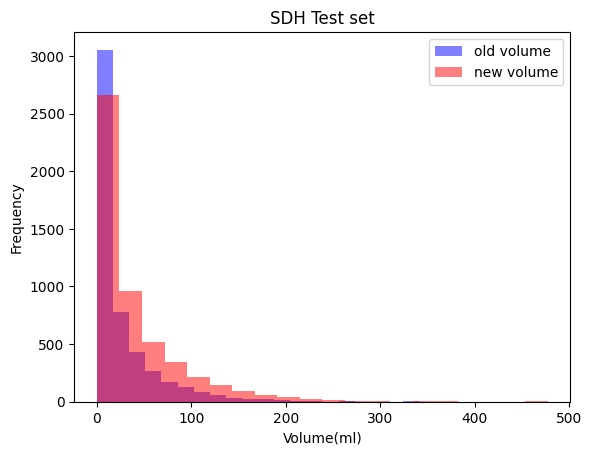

In [399]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists of numbers)

# Plot histogram for list1
plt.hist(old_volume, bins=20, alpha=0.5, label='old volume', color='blue')

# Plot histogram for list2
plt.hist(new_volume, bins=20, alpha=0.5, label='new volume', color='red')

# Add labels and title
plt.xlabel('Volume(ml)')
plt.ylabel('Frequency')
plt.title('SDH Test set')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [393]:
import glob
from os import path
example_files = "/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/"
zips_to_extract = glob.glob(path.join(example_files, "*.zip"))



In [394]:
zips_to_extract

['/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/KGH23428.zip',
 '/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/zeroml_test.zip',
 '/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/example_files/hemorrhages_quantification/SHM9055.zip']

In [413]:
zip_to_extract = path.join("/home/users/shubham.kumar/projects/qureai/packages/python/qer/tests/ai/predictor/", "../example_files/hemorrhages_quantification/zeroml_test.nii.gz")


In [415]:
im = sitk.ReadImage(zip_to_extract)

In [417]:
im.GetSize()

(512, 512, 32)

In [414]:
os.path.exists(zip_to_extract)

True

In [411]:
import zipfile

In [ ]:
with zipfile.ZipFile(f) as zip_ref:
    zip_ref.extractall(example_files)

In [4]:
import pandas as pd
from tqdm.auto import tqdm
import os
df_fda_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")
fda_study_uids = df_fda_test.StudyUID.values
for study_uid in tqdm(fda_study_uids) : 
    if os.path.exists(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{study_uid}.h5") : 
        print("yes")

  0%|          | 0/372 [00:00<?, ?it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [48]:
fda_uids = df_fda.StudyUID.unique()

In [49]:
def get_dev_headct_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')

        if "mask" not in f2.keys():
            base_path = "/cache/fast_data_nas8/qer/shubham/ich_seg_train_val"
            path = os.path.join(base_path, study_uid)
            h5_data = path + '.h5'
            f2 = h5py.File(h5_data, 'r')
            image = f2['image']
            mask = f2["mask"]
            arr = np.array(image)
            mask = np.array(mask)
            f2.close()
            return arr ,mask
        
        image = f2['image']
        mask = f2["mask"]
        arr = np.array(image)
        mask = np.array(mask)
        f2.close()
        return arr, mask
    else:
        return None

In [ ]:

old_volume = []
new_volume = []
for uid in tqdm(fda_uids) : 
    if os.path.exists(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5") : 
        h5f = h5py.File(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5" , "r")
        old_volume.append(np.array(h5f["acute_pp_vol"]).item())

In [1]:
df_abs_vol =pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/dice_score_old_prod.csv")


NameError: name 'pd' is not defined

In [68]:
df_abs_vol

,StudyUID,Dataset,dice_score,dice_score_pp
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.572880,0.872709
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,FDA,0.193878,0.473739
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,FDA,0.666394,0.829633
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,FDA,0.000000,0.000000
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,FDA,0.000000,0.000000
...,...,...,...,...
2309,1.2.840.113619.2.55.3.2831165733.91.1415244174...,train,0.252540,0.419143
2310,1.2.840.113619.2.81.290.1.1913.20130405.302130,train,0.449312,0.519675
2311,1.2.840.113619.2.278.3.2831165735.386.12988577...,train,0.010464,0.074163
2312,1.2.840.113619.2.55.3.2831165733.104.142174775...,train,0.429167,0.597790


In [55]:

percentile_90 = np.percentile(df_abs_vol[df_abs_vol["dataset"] == "train"].abs_vol_error.values,90) 

In [63]:
out = {}
a = np.percentile(df_abs_vol[df_abs_vol["dataset"] == "train"].abs_vol_error.values,90) 
out.update({"train_abs_vol_error_pp" : a})
b = np.percentile(df_abs_vol[df_abs_vol["dataset"] == "val"].abs_vol_error.values,90) 
out.update({"val_abs_vol_error_pp" : b})

c = np.percentile(df_abs_vol[df_abs_vol["dataset"] != "FDA"].abs_vol_error.values,90) 
out.update({"dev_abs_vol_error_pp" : c})

d = np.percentile(df_abs_vol[df_abs_vol["dataset"] == "FDA"].abs_vol_error.values,90) 
out.update({"fda_abs_vol_error_pp" : d})

e = np.percentile(df_abs_vol.abs_vol_error.values,90) 
out.update({"all_abs_vol_error_pp" : e})



In [71]:
pd.DataFrame([out])

,train_dice_score_pp,val_dice_score_pp,dev_dice_score_pp,fda_dice_score_pp,all_dice_score_pp
0,0.524148,0.551222,0.530109,0.671212,0.552671


In [72]:
out = {}
a = np.mean(df_abs_vol[df_abs_vol["Dataset"] == "train"].dice_score.values) 
out.update({"train_dice_score" : a})
b = np.mean(df_abs_vol[df_abs_vol["Dataset"] == "val"].dice_score.values) 
out.update({"val_dice_score" : b})

c = np.mean(df_abs_vol[df_abs_vol["Dataset"] != "FDA"].dice_score.values) 
out.update({"dev_dice_score" : c})

d = np.mean(df_abs_vol[df_abs_vol["Dataset"] == "FDA"].dice_score.values) 
out.update({"fda_dice_score" : d})

e = np.mean(df_abs_vol.dice_score.values) 
out.update({"all_dice_score" : e})

In [73]:
pd.DataFrame([out])

,train_dice_score,val_dice_score,dev_dice_score,fda_dice_score,all_dice_score
0,0.450874,0.491376,0.459791,0.552799,0.474663


In [14]:
p = "/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances"

k = os.listdir("/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances")




In [15]:
f = [os.path.join(p , i) for i in k ]

In [16]:
f

['/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.8698044342088767179.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.4797278141045663641.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.1458583925831026433.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.113727611578435225.dcm',
 '/home/u

In [19]:
img = load_raw_sitk_img(p)

IndexError: list index out of range

In [34]:
f

['/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.8698044342088767179.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.4797278141045663641.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.1458583925831026433.dcm',
 '/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances/1.2.826.0.1.3680043.9.7508.1.804017975.113727611578435225.dcm',
 '/home/u

In [26]:
import qure_mini_pacs

In [40]:
a,b,c = qure_mini_pacs.create_documents("/home/users/shubham.kumar/projects/ra/studies/1.2.826.0.1.3680043.9.7508.1.804017975.2729981825968818386/series/1.2.826.0.1.3680043.9.7508.1.804017975.7725277782538407293/instances")



In [35]:
from pydicom import dcmread

In [47]:
a = dcmread(f[0])

InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

In [6]:
from qer.utils.db import get_mongo_db
db = get_mongo_db()
import pandas as pd
# Below , in each row of csv we have a corresponding SeriesUID for each StudyUID
df = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_qure25k.csv")

df_blend_score = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_ICH_blend_output.csv")


In [3]:
df_fda = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_fda.csv")
df_fda = df_fda[df_fda["threshold"] == 0.5]

In [48]:
# ans = []
for idx in tqdm(df.index) :
    
    suid = df.loc[idx , "SeriesUID"]
    uid = df.loc[idx , "StudyUID"]
    if uid in done_uids :
        continue
    
    dest_dir = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/{uid}"
    if os.path.exists(dest_dir) : 
        try : 
            out = load_and_run_model("hemorrhages_v3",dest_dir) 
            v3_score = out['results']['scores']['ICH']

            out = load_and_run_model("hemorrhages_quantification",dest_dir) 
            volume = out['results']['quantification value']['ICH']
            ans.append({"StudyUID" : uid , "v3_score" : v3_score , "quant_volume":volume})
        except KeyboardInterrupt:
            break
        except Exception as e:
            print(e)
            continue


  0%|          | 0/372 [00:00<?, ?it/s]

[2023-09-18 21:20:22 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:20:25 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:20:25 +0530] [INFO] Loading model hemorrhages_quantification


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


[2023-09-18 21:20:28 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:20:30 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:20:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.84 to 4.90
[2023-09-18 21:20:33 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.133375



[2023-09-18 21:20:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.84 to 4.90


ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.133375



[2023-09-18 21:20:36 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:20:39 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.54
[2023-09-18 21:20:39 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:20:42 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.54
[2023-09-18 21:20:44 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:20:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:20:47 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:20:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:20:52 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:20:54 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 7.13
[2023-09-18 21:20:54 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:20:56

ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000774194



[2023-09-18 21:22:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.05 to 5.05


ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000774194



[2023-09-18 21:22:47 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:22:49 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.79 to 5.01


ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.40488



[2023-09-18 21:22:50 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:22:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.79 to 5.01


ImageSeriesReader (0xec52ad20): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.40488



[2023-09-18 21:22:53 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:22:56 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 2.89
[2023-09-18 21:22:57 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:22:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 2.89
[2023-09-18 21:23:02 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:23:04 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:23:04 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:23:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:23:07 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:23:10 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:23:10 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:23:12

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.47237



[2023-09-18 21:24:14 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.80 to 2.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.47237



[2023-09-18 21:24:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:21 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:24 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:26 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:28 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:31 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.54 to 5.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:24:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.54 to 5.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:24:34 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:38 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:24:38 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:42 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:24:45 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:47 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:49 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:51 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:24:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:24:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:24:53

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000771429



[2023-09-18 21:24:58 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:00 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.09 to 5.09


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000771429



[2023-09-18 21:25:01 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:04 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.01 to 5.05


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.63323



[2023-09-18 21:25:04 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.01 to 5.05


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.63323



[2023-09-18 21:25:08 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:10 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.15 to 5.15
[2023-09-18 21:25:10 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00155556



[2023-09-18 21:25:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.15 to 5.15


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00155556



[2023-09-18 21:25:13 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.13 to 5.13
[2023-09-18 21:25:16 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00129032



[2023-09-18 21:25:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.13 to 5.13


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00129032



[2023-09-18 21:25:19 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:25:23 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:25:29 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:31 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:25:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:25:40 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 6.29


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000681847



[2023-09-18 21:25:41 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:42 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 6.29


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000681847



[2023-09-18 21:25:44 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:25:46 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:48 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:25:50 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:25:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:54 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:25:55 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:25:56 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.42 to 2.44


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.136738



[2023-09-18 21:25:57 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:25:58 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.42 to 2.44


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.136738



[2023-09-18 21:26:01 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:26:04 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:26:04 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:26:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:26:10 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:26:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000996212



[2023-09-18 21:26:22 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:26:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000996212



[2023-09-18 21:26:44 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:26:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.71


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000751552



[2023-09-18 21:26:48 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:26:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.71


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000751552



[2023-09-18 21:26:53 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:26:56 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.38


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000911261



[2023-09-18 21:26:57 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:26:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.38


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000911261



[2023-09-18 21:27:02 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:27:17 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.50
[2023-09-18 21:27:19 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:27:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.50
[2023-09-18 21:27:49 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:27:51 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:27:51 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:27:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:27:54 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:27:57 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:27:57 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:27:59

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.01925



[2023-09-18 21:28:03 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.17 to 5.17


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.01925



[2023-09-18 21:28:05 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:28:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.00 to 4.00
[2023-09-18 21:28:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:28:09 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.00 to 4.00
[2023-09-18 21:28:11 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:28:14 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.00 to 4.00
[2023-09-18 21:28:14 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:28:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.00 to 4.00
[2023-09-18 21:28:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:28:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:28:21 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:28:23

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:29:03 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:29:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.51 to 2.51


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:29:09 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:29:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.31 to 5.03
[2023-09-18 21:29:12 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.622563



[2023-09-18 21:29:14 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.31 to 5.03


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.622563



[2023-09-18 21:29:15 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:29:17 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.31 to 5.05
[2023-09-18 21:29:17 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.595517



[2023-09-18 21:29:19 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.31 to 5.05


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.595517



[2023-09-18 21:29:20 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:29:24 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:29:24 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:29:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:29:29 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:29:30 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:29:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:29:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:29:33 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:29:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.61
[2023-09-18 21:29:47 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:29:59

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000809132



[2023-09-18 21:31:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 7.41


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000809132



[2023-09-18 21:31:15 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:31:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.97


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000725284



[2023-09-18 21:31:17 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:31:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.97


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000725284



[2023-09-18 21:31:21 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:31:24 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.74 to 2.74


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000619718



[2023-09-18 21:31:25 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:31:28 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.74 to 2.74


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000619718



[2023-09-18 21:31:31 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:31:34 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:31:34 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:31:37 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:31:40 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:31:43 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.58 to 2.59


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0403513



[2023-09-18 21:31:43 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:31:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.58 to 2.59


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0403513



[2023-09-18 21:31:49 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:31:51 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.72 to 2.58


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.44114



[2023-09-18 21:31:51 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:31:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.72 to 2.58


ImageSeriesReader (0x28b63b20): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.44114



[2023-09-18 21:31:54 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:32:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.60 to 0.60
[2023-09-18 21:32:26 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:32:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.43 to 5.43


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000742857



[2023-09-18 21:32:27 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:32:28 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.43 to 5.43


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000742857



[2023-09-18 21:32:30 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:32:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.65 to 2.65


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000873016



[2023-09-18 21:32:34 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:32:37 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.65 to 2.65


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000873016



[2023-09-18 21:32:39 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:32:43 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.60


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00082121



[2023-09-18 21:32:44 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:32:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.60


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00082121



[2023-09-18 21:32:50 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:32:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:33:00 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:33:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:33:15 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:33:17 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.11 to 5.34


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.64706



[2023-09-18 21:33:17 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:33:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.11 to 5.34


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.64706



[2023-09-18 21:33:20 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:33:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:33:23 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:33:25 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:33:27 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:33:40 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-09-18 21:33:41 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:33:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-09-18 21:34:06 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:34:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:34:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:34:08

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000515152



[2023-09-18 21:34:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000515152



[2023-09-18 21:34:20 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:34:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.03 to 5.14


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.59481



[2023-09-18 21:34:22 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:34:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.03 to 5.14


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.59481



[2023-09-18 21:34:24 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:34:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 3.24
[2023-09-18 21:34:26 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:34:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 3.24
[2023-09-18 21:34:29 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:34:31 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000963154



[2023-09-18 21:34:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:34:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000963154



[2023-09-18 21:34:34 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:34:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-09-18 21:34:47 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:34:57 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-09-18 21:35:09 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:35:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.34


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000763018



[2023-09-18 21:35:11 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:35:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.34


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000763018



[2023-09-18 21:35:14 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:35:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:35:19 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:35:22 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:35:26 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:35:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.25 to 1.25


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000748428



[2023-09-18 21:35:34 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:35:40 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.25 to 1.25


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000748428



[2023-09-18 21:35:47 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:35:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.64 to 0.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000811765



[2023-09-18 21:35:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:35:55 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.64 to 0.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000811765



[2023-09-18 21:36:05 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:36:14 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:36:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:36:28 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:31 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 2.94
[2023-09-18 21:36:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:36:34 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 2.94
[2023-09-18 21:36:37 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:38 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:36:38 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:36:39

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.13793



[2023-09-18 21:36:48 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.86 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.13793



[2023-09-18 21:36:49 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:51 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.69 to 5.00
[2023-09-18 21:36:51 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.31034



[2023-09-18 21:36:51 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.69 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:9.31034



[2023-09-18 21:36:53 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:54 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:36:54 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000871875



[2023-09-18 21:36:56 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000871875



[2023-09-18 21:36:57 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:36:58 +0530] [INFO] Correcting image z spacing using median of slice positions from 7.89 to 5.00
[2023-09-18 21:36:58 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:17.1053



[2023-09-18 21:36:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 7.89 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:17.1053



[2023-09-18 21:37:00 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:01 +0530] [INFO] Correcting image z spacing using median of slice positions from 6.40 to 5.00
[2023-09-18 21:37:02 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:3.6



[2023-09-18 21:37:03 +0530] [INFO] Correcting image z spacing using median of slice positions from 6.40 to 5.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:3.6



[2023-09-18 21:37:04 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:05 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:37:05 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:37:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:37:08 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:10 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.04 to 3.12


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.538801



[2023-09-18 21:37:10 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:37:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.04 to 3.12


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.538801



[2023-09-18 21:37:14 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:37:15 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:37:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:37:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.05
[2023-09-18 21:37:21 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:37:22 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.05
[2023-09-18 21:37:25 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:37:29 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.50
[2023-09-18 21:37:31 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:37:35

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94737



[2023-09-18 21:39:10 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.05 to 3.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94737



[2023-09-18 21:39:14 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.05 to 3.00


ImageSeriesReader (0x28b63b20): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94643



[2023-09-18 21:39:16 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:17 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.05 to 3.00


ImageSeriesReader (0x28b63b20): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94643



[2023-09-18 21:39:20 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.07 to 5.11


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.5109



[2023-09-18 21:39:22 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.07 to 5.11


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.5109



[2023-09-18 21:39:25 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.54 to 2.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000507042



[2023-09-18 21:39:27 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:29 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.54 to 2.54


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000507042



[2023-09-18 21:39:32 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:34 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:39:34 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:39:38 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:40 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.23 to 5.23
[2023-09-18 21:39:40 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.23 to 5.23
[2023-09-18 21:39:42 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:43 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:39:44 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:45

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:4.94368



[2023-09-18 21:39:48 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:49 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.24 to 5.09


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:4.94368



[2023-09-18 21:39:50 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:39:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:39:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:39:54 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:39:58 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:00 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.62 to 2.55


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.48548



[2023-09-18 21:40:00 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:02 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.62 to 2.55


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.48548



[2023-09-18 21:40:05 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:40:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:08 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:40:11 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.57 to 2.57


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:40:13 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.57 to 2.57


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:40:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:19 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.52 to 2.52


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000619718



[2023-09-18 21:40:19 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.52 to 2.52


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000619718



[2023-09-18 21:40:24 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.64 to 2.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000760563



[2023-09-18 21:40:26 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.64 to 2.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000760563



[2023-09-18 21:40:31 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.79 to 2.79


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000507042



[2023-09-18 21:40:33 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.79 to 2.79


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000507042



[2023-09-18 21:40:38 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:39 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.51 to 2.51


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:40:40 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.51 to 2.51


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:40:44 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.51 to 2.51


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000620253



[2023-09-18 21:40:46 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:48 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.51 to 2.51


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000620253



[2023-09-18 21:40:51 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.69 to 2.69


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00101587



[2023-09-18 21:40:53 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:40:55 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.69 to 2.69


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00101587



[2023-09-18 21:40:57 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:40:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.14 to 5.14
[2023-09-18 21:40:59 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:00 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.14 to 5.14
[2023-09-18 21:41:02 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:03 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.01 to 5.01
[2023-09-18 21:41:03 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:04 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.01 to 5.01


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:05 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.61 to 5.61


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:08 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.61 to 5.61


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:10 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.14 to 5.14
[2023-09-18 21:41:11 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.14 to 5.14
[2023-09-18 21:41:14 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.02 to 5.02
[2023-09-18 21:41:16 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000516129



[2023-09-18 21:41:17 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.02 to 5.02


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000516129



[2023-09-18 21:41:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.27 to 5.27
[2023-09-18 21:41:20 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.27 to 5.27
[2023-09-18 21:41:22 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.11 to 5.11
[2023-09-18 21:41:24 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:24 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.11 to 5.11


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:41:26 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:28 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.60 to 2.60


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:41:28 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:29 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.60 to 2.60


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746032



[2023-09-18 21:41:32 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:36 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000996078



[2023-09-18 21:41:37 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:40 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000996078



[2023-09-18 21:41:51 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.65 to 2.57


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.48113



[2023-09-18 21:41:53 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:41:55 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.65 to 2.57


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.48113



[2023-09-18 21:41:57 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:41:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.64 to 2.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746479



[2023-09-18 21:42:00 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:01 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.64 to 2.64


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000746479



[2023-09-18 21:42:04 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.55 to 2.55


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000761905



[2023-09-18 21:42:06 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.55 to 2.55


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000761905



[2023-09-18 21:42:10 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.68 to 2.68


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000873239



[2023-09-18 21:42:12 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.68 to 2.68


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000873239



[2023-09-18 21:42:16 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.622845



[2023-09-18 21:42:22 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.63 to 0.62


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.622845



[2023-09-18 21:42:38 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:39 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:42:39 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:42:43 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:42:46 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:42:50 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:42:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:42:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:42:54

[2023-09-18 21:44:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:44:43 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:44:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:44:45 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:44:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:44:48 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:44:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:44:50 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:44:51 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.75 to 3.75
[2023-09-18 21:44:53 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:44:55 +0530] [INFO] Correcting image z spacing using median of slice positions fr

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000780959



[2023-09-18 21:45:12 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 2.36


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000780959



[2023-09-18 21:45:17 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:19 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:19 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:22 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:24 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:24 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:25 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:28 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:30 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.03


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000865902



[2023-09-18 21:45:30 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.03


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000865902



[2023-09-18 21:45:34 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:36 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.06 to 3.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.93878



[2023-09-18 21:45:36 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:37 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.06 to 3.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.93878



[2023-09-18 21:45:39 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:41 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:42 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:45 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:47 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:48 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:50 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:45:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.00
[2023-09-18 21:45:52 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:45:53

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:8.83218



[2023-09-18 21:46:15 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.77 to 3.17


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:8.83218



[2023-09-18 21:46:18 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:46:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.55
[2023-09-18 21:46:20 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:21 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.00 to 3.55
[2023-09-18 21:46:24 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:46:25 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.58 to 2.58


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00463064



[2023-09-18 21:46:26 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:27 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.58 to 2.58


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.00463064



[2023-09-18 21:46:30 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:46:31 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.84
[2023-09-18 21:46:32 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.84
[2023-09-18 21:46:34 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:46:37 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:46:38 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:40 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-09-18 21:46:47 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:46:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.01 to 1.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.993865



[2023-09-18 21:46:51 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:46:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.01 to 1.00


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.993865



[2023-09-18 21:47:00 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:01 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.05 to 3.00


ImageSeriesReader (0x28b63b20): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94545



[2023-09-18 21:47:01 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:03 +0530] [INFO] Correcting image z spacing using median of slice positions from 3.05 to 3.00


ImageSeriesReader (0x28b63b20): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.94545



[2023-09-18 21:47:05 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:06 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.04 to 5.96
[2023-09-18 21:47:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:08 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.04 to 5.96
[2023-09-18 21:47:09 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:47:11 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:47:13 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.38
[2023-09-18 21:47:16 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:17

ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.76191



[2023-09-18 21:47:42 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:43 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.21 to 5.47


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.76191



[2023-09-18 21:47:45 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:47 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.10 to 5.10


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000514286



[2023-09-18 21:47:48 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:49 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.10 to 5.10


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000514286



[2023-09-18 21:47:51 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:47:53 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:47:53 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:47:55 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00
[2023-09-18 21:47:57 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:01 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.001



[2023-09-18 21:48:01 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:05 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.001



[2023-09-18 21:48:08 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:48:13 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:16 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:48:19 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:48:23 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:26 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:48:29 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:32 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.47 to 5.49


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.72644



[2023-09-18 21:48:32 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 4.47 to 5.49


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.72644



[2023-09-18 21:48:37 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:39 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.30 to 5.30
[2023-09-18 21:48:39 +0530] [INFO] Loading model hemorrhages_quantification


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:48:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.30 to 5.30


ImageSeriesReader (0xee7e5580): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000741935



[2023-09-18 21:48:42 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:44 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.27 to 5.27
[2023-09-18 21:48:44 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.27 to 5.27
[2023-09-18 21:48:46 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:48:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.25 to 1.25
[2023-09-18 21:48:53 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:48:58 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.25 to 1.25
[2023-09-18 21:49:04 +0530] [INFO] Loading model hemorrhages_v3
[2023-09-18 21:49:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 2.50 to 2.50
[2023-09-18 21:49:07 +0530] [INFO] Loading model hemorrhages_quantification
[2023-09-18 21:49:10

In [56]:
#pd.DataFrame.from_records(ans).to_csv("final_fda_data_to_work.csv", index =False)

In [113]:
os.listdir("/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/")

['1.2.840.113619.2.437.3.420137064.70.1596354183.183',
 '1.2.392.200036.9116.2.6.1.48.1221406771.1573557162.627753',
 '1.2.840.113619.2.359.3.669450.20.1573708251.896',
 '1.2.276.0.7230010.3.1.2.8323329.1346.1548125490.897518',
 '1.2.276.0.7230010.3.1.2.8323329.1346.1548359679.908596',
 '1.2.276.0.7230010.3.1.2.8323329.1346.1548665474.1025571']

In [49]:
df_ans = pd.DataFrame.from_records(ans)

In [50]:
df_ans

,StudyUID,v3_score,quant_volume
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,0.975272,11.870062
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,0.999240,86.999359
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,0.993408,168.256111
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,0.928771,8.646837
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,0.989345,11.495852
...,...,...,...
366,1.2.840.113619.2.437.3.2164967700.762.16018707...,0.809751,3.258140
367,1.2.840.113619.2.437.3.330089073.841.160197097...,0.861972,2.917511
368,1.2.840.114350.2.450.2.798268.2.204004709.1,0.997943,37.051997
369,1.2.840.114350.2.450.2.798268.2.205470431.1,0.903342,2.251265


In [86]:
# uids = df_fda[(df_fda["pred_volume_pp"] <= 0.05)].StudyUID.values
# uid = df_fda[(df_fda["pred_volume_pp"] <= 0.2) & df_fda["pred_volume_pp"] > 0.05].StudyUID.values[0]
# uids = df_fda[(df_fda["pred_volume_pp"] > 0.2)].StudyUID.values
# uids = df_fda[(df_fda["pred_volume_pp"] <= 1) & (df_fda["pred_volume_pp"] > 0.2)].StudyUID.values
uids = df_fda[(df_fda["pred_volume_pp"] > 1)].StudyUID.values



In [51]:
req_df = df_ans[(df_ans["v3_score"] >= 0.56)]

In [24]:
req_df[(req_df["quant_volume"] <=1) & (req_df["quant_volume"] >0.2)].StudyUID.values

array(['1.2.840.113619.2.404.3.1611285236.107.1573629463.553',
       '1.2.840.113619.2.452.3.447493197.631.1574503272.546',
       '1.2.840.113696.513556.510.1357561.20191112205144',
       '1.2.392.200036.9116.2.6.1.37.2418725291.1577807191.133311'],
      dtype=object)

In [55]:
req_df[(req_df["quant_volume"] < 0.2)]

,StudyUID,v3_score,quant_volume


In [84]:
df_fda[(df_fda["pred_volume_pp"] > 1)]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
9,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,FDA,0.5,0.803972,7.473047,2.295151,0.884267,11.580682,1.812485,0.814723,7.245520,2.522678
28,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,FDA,0.5,0.485887,52.735474,63.807495,0.673430,108.808594,7.734375,0.505736,45.770142,70.772827
47,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,FDA,0.5,0.761908,222.478877,71.289466,0.857350,276.063398,17.704946,0.797816,199.243818,94.524525
66,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,FDA,0.5,0.087675,0.196695,3.359314,0.426782,1.963375,1.592634,0.087675,0.196695,3.359314
85,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,FDA,0.5,0.000000,5.996227,5.279779,0.000000,12.961626,12.245178,0.000000,2.957582,2.241135
...,...,...,...,...,...,...,...,...,...,...,...,...
6944,1.2.840.113619.2.428.3.571108510.909.160173547...,FDA,0.5,0.188373,1.255273,4.400010,0.378150,6.216758,0.561475,0.194826,1.026391,4.628892
6963,1.2.840.113619.2.437.3.2164967700.762.16018707...,FDA,0.5,0.616796,1.467665,1.630174,0.785640,2.984844,0.112995,0.624261,1.413072,1.684768
6982,1.2.840.113619.2.437.3.330089073.841.160197097...,FDA,0.5,0.444819,3.931518,8.393517,0.317181,2.460477,9.864559,0.227989,1.593827,10.731209
7001,1.2.840.114350.2.450.2.798268.2.204004709.1,FDA,0.5,0.737159,40.550190,0.782012,0.781629,37.779769,3.552433,0.798926,34.121240,7.210963


In [89]:
 df_blend_score[(df_blend_score["StudyUID"].isin(uids)) & (df_blend_score["blend_score"] > 0.56) ]

,StudyUID,SeriesUID,NumInstances,volume,length,thickness,blend_score,ICH,IVH,SDH,SAH,EDH,CONT,ANY
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,1.2.276.0.7230010.3.1.3.8323329.1346.154812549...,34,9.768198,96,49,0.837999,0,0,0,0,1,0,1
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,1.2.276.0.7230010.3.1.3.8323329.1346.154835968...,46,87.407227,355,295,0.999179,0,0,1,1,0,1,1
2,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,1.2.276.0.7230010.3.1.3.8323329.1346.154841463...,31,0.719314,121,134,0.960284,0,0,1,0,0,0,1
3,1.2.276.0.7230010.3.1.2.8323329.1346.154841463...,1.2.276.0.7230010.3.1.3.8323329.1346.154841464...,33,19.489527,99,93,0.957765,1,0,0,1,0,0,1
5,1.2.276.0.7230010.3.1.2.8323329.1346.154867253...,1.2.276.0.7230010.3.1.3.8323329.1346.154867253...,36,39.843882,266,121,0.955206,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.2.840.113619.2.411.3.168438018.869.160362314...,1.2.840.113619.2.411.3.168438018.869.160362314...,36,27.261229,150,114,0.739557,1,0,0,1,0,0,1
164,1.2.840.113619.2.416.1761149958164321767726696...,1.2.840.113619.2.416.1680018544693049743932110...,37,36.580171,331,176,0.973598,0,0,1,0,0,1,1
165,1.2.840.113619.2.428.3.571108510.909.160173547...,1.2.840.113619.2.428.3.571108510.909.160173547...,44,6.209501,199,96,0.822804,0,0,1,0,0,0,1
166,1.2.840.113619.2.437.3.2164967700.762.16018707...,1.2.840.113619.2.437.3.2164967700.762.16018707...,32,3.283710,322,194,0.850151,0,0,1,0,0,0,1


In [95]:
df_blend_score[df_blend_score["blend_score"] < 0.56]

,StudyUID,SeriesUID,NumInstances,volume,length,thickness,blend_score,ICH,IVH,SDH,SAH,EDH,CONT,ANY
36,1.2.840.113619.2.340.3.3523929760.378.15734700...,1.2.840.113619.2.340.3.3523929760.378.15734700...,36,0.604425,22,23,0.054932,0,0,0,0,0,0,0
37,1.2.840.113619.2.359.3.669450.20.1573708251.896,1.2.840.113619.2.359.3.669450.20.1573708251.909,28,12.099087,61,109,0.553248,1,0,0,0,0,0,1
72,1.2.840.114350.2.186.2.798268.2.298710499.1,1.3.12.2.1107.5.1.4.64797.30000019111315074988...,33,7.872770,132,72,0.413526,0,0,1,0,0,0,1
155,1.2.840.113619.2.55.3.1762297613.729.156860465...,1.2.840.113619.2.55.3.1762297613.729.156860465...,45,0.499329,148,132,0.160001,1,0,0,0,0,0,1
161,1.2.392.200036.9116.2.6.1.44063.1805253169.160...,1.2.392.200036.9116.2.6.1.44063.1805253169.160...,28,0.423781,49,59,0.528269,0,0,0,0,0,0,0


'1.2.840.113619.2.359.3.669450.20.1573708251.909'

In [106]:
uid = df_fda[(df_fda["StudyUID"].isin(df_blend_score[df_blend_score["blend_score"] < 0.56].StudyUID.values)) & (df_fda["pred_volume_pp"] > 0)].loc[1643].StudyUID
series_uid = df_blend_score[df_blend_score["StudyUID"] == uid].SeriesUID.values[0]



In [90]:
uid = df_blend_score[(df_blend_score["StudyUID"].isin(uids)) & (df_blend_score["blend_score"] > 0.56) ].loc[1].StudyUID
series_uid = df_blend_score[(df_blend_score["StudyUID"].isin(uids)) &(df_blend_score["blend_score"] > 0.56) ].loc[1].SeriesUID



In [57]:
uid = df_blend_score[df_blend_score["StudyUID"].isin(uids)].StudyUID.values[0]
series_uid = df_blend_score[df_blend_score["StudyUID"].isin(uids)].SeriesUID.values[0]

In [50]:
# series_uid = '1.2.840.113619.2.437.3.420137064.70.1596354183.190'
# uid = df_blend_score[df_blend_score["StudyUID"].isin(df_fda[df_fda["pred_volume_pp"] <= 0.05].StudyUID.values)].loc[136].StudyUID


In [112]:
# Just use the series_uid we get from above to get the list of dicoms filepaths
import os

for idx in df_test.index :
    uid = df_test.loc[idx, "StudyUID"]
    series_uid = df_test.loc[idx, "SeriesUID"]
    series_dict = db.dicoms.find_one({"_id" : series_uid })
 
    filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
    new_filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]

    invalid_paths = False
    for path in new_filepaths :
        if not os.path.exists(path) :
            invalid_paths = True
            break

    if invalid_paths : 
        new_filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]

        for i in range(len(new_filepaths)): 
            source = new_filepaths[i]

            # Destination path
            dest_dir = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/{uid}"
            if not os.path.exists(dest_dir) :
                os.mkdir(dest_dir)
            destination = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/{uid}/{os.path.basename(source)}"

            # Copy the content of
            # source to destination

            try:
                shutil.copy(source, destination)
                print("File copied successfully.")

            # If source and destination are same
            except shutil.SameFileError:
                print("Source and destination represents the same file.")

            # If there is any permission issue
            except PermissionError:
                print("Permission denied.")

            # For other errors
            except:
                print("Error occurred while copying file.")


File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

In [60]:
# Source path
import shutil
for i in range(len(new_filepaths)): 
    source = new_filepaths[i]

    # Destination path
    dest_dir = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/{uid}"
    if not os.path.exists(dest_dir) :
        os.mkdir(dest_dir)
    destination = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/{uid}/{os.path.basename(source)}"

    # Copy the content of
    # source to destination

    try:
        shutil.copy(source, destination)
        print("File copied successfully.")

    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")

    # If there is any permission issue
    except PermissionError:
        print("Permission denied.")

    # For other errors
    except:
        print("Error occurred while copying file.")

Error occurred while copying file.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
Fil

In [37]:
out = load_and_run_model("hemorrhages_v3", f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/prod_test_cases_v2/{uid}")


[2023-09-15 19:04:04 +0530] [INFO] Loading model hemorrhages_blend
[2023-09-15 19:04:11 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-09-15 19:04:11 +0530] [INFO] Loading model hemorrhages_v3


ImageSeriesReader (0xe4f2e510): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0001



[2023-09-15 19:04:12 +0530] [INFO] Loading model hemorrhages
[2023-09-15 19:04:14 +0530] [INFO] Resampling image; original thickness: 0.80; target thickness:  4.80
[2023-09-15 19:04:15 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-09-15 19:04:15 +0530] [INFO] Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
out["results"]["scores"]["ICH"]

{'results': {'scores': {'ICH': 0.6186153491338094}}}

In [107]:
li.append({"SeriesUID": series_uid , "StudyUID" : uid , "Testing Data" : "Bonus test case" })

In [51]:
# li.append({"SeriesUID": series_uid , "StudyUID" : uid , "Testing Data" : "0 Volume ICH test case" })

In [109]:
pd.DataFrame(li).to_csv("testing_ICH_quant.csv" , index =False)

In [110]:
df_test = pd.DataFrame(li)

In [111]:
df_test

,SeriesUID,StudyUID,Testing Data
0,1.2.392.200036.9116.2.6.1.48.1221406771.157355...,1.2.392.200036.9116.2.6.1.48.1221406771.157355...,Volume thresholding test case (a)
1,1.2.840.113619.2.437.3.420137064.70.1596354183...,1.2.840.113619.2.437.3.420137064.70.1596354183...,0 Volume ICH test case
2,1.2.276.0.7230010.3.1.3.8323329.1346.154812549...,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,Volume thresholding test case (b)
3,1.2.276.0.7230010.3.1.3.8323329.1346.154866547...,1.2.276.0.7230010.3.1.2.8323329.1346.154866547...,TBR test case-1 (a)
4,1.2.276.0.7230010.3.1.3.8323329.1346.154835968...,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,TBR test case-1 (b)
5,1.2.840.113619.2.359.3.669450.20.1573708251.909,1.2.840.113619.2.359.3.669450.20.1573708251.896,Bonus test case


In [ ]:
# Just use the series_uid we get from above to get the list of dicoms filepaths
import os

for idx in tqdm(df.index) :
    uid = df.loc[idx, "StudyUID"]
    series_uid = df.loc[idx, "SeriesUID"]
    series_dict = db.dicoms.find_one({"_id" : series_uid })
 
    filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
    new_filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]

    invalid_paths = False
    for path in new_filepaths :
        if not os.path.exists(path) :
            invalid_paths = True
            break

    if invalid_paths : 
        new_filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]

        for i in range(len(new_filepaths)): 
            source = new_filepaths[i]

            # Destination path
            dest_dir = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/{uid}"
            if not os.path.exists(dest_dir) :
                os.mkdir(dest_dir)
            destination = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/{uid}/{os.path.basename(source)}"

            # Copy the content of
            # source to destination

            try:
                shutil.copy(source, destination)
                print("File copied successfully.")

            # If source and destination are same
            except shutil.SameFileError:
                print("Source and destination represents the same file.")

            # If there is any permission issue
            except PermissionError:
                print("Permission denied.")

            # For other errors
            except:
                print("Error occurred while copying file.")


  0%|          | 0/372 [00:00<?, ?it/s]

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
Error occurred while copying file.
File copied successfully.
File copied successfully.
File copied successfully.


In [29]:
df

,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CALVARIAL,FRAC,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER
0,1.2.276.0.7230010.3.1.2.8323329.1346.154812549...,a990aa77-941e-459e-abef-f89662f48560,qure25k,test_set_trs/sampled/anonymized1496.nii.gz,1.2.276.0.7230010.3.1.3.8323329.1346.154812549...,test_set_trs,NaN,0,0,1,...,1,1,0,0,0,NaN,1,NaN,20.0,TOSHIBA
1,1.2.276.0.7230010.3.1.2.8323329.1346.154835967...,093127e7-f66a-4327-a71a-ce162e1c4c71,qure25k,test_set_trs/sampled/anonymized1530.nii.gz,1.2.276.0.7230010.3.1.3.8323329.1346.154835968...,test_set_trs,NaN,0,1,0,...,0,1,0,0,0,NaN,1,NaN,98.0,GE MEDICAL SYSTEMS
2,1.2.276.0.7230010.3.1.2.8323329.1346.154839219...,49ada4c4-be70-40b8-a7d4-57b8a1f5c238,qure25k,test_set_trs/sampled/anonymized1555.nii.gz,1.2.276.0.7230010.3.1.3.8323329.1346.154839223...,test_set_trs,NaN,0,1,0,...,1,1,0,0,0,NaN,1,NaN,64.0,GE MEDICAL SYSTEMS
3,1.2.276.0.7230010.3.1.2.8323329.1346.154839357...,fc0ce2fb-9ec9-408f-828d-26fc448313b3,qure25k,test_set_trs/sampled/anonymized1570.nii.gz,1.2.276.0.7230010.3.1.3.8323329.1346.154839358...,test_set_trs,NaN,0,0,0,...,0,0,0,0,0,NaN,1,NaN,83.0,GE MEDICAL SYSTEMS
4,1.2.276.0.7230010.3.1.2.8323329.1346.154841462...,5f6bf58e-741d-4aff-816e-5eb0b201dfe1,qure25k,test_set_trs/sampled/anonymized1629.nii.gz,1.2.276.0.7230010.3.1.3.8323329.1346.154841463...,test_set_trs,NaN,0,1,0,...,0,0,0,0,0,NaN,1,NaN,77.0,Philips
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,1.2.840.113619.2.437.3.2164967700.762.16018707...,MRN#12345,qure25k,test_set_vRad_6/sampled/1.2.840.113619.2.437.3...,1.2.840.113619.2.437.3.2164967700.762.16018707...,test_set_vRad_6,nii.gz attempted,0,1,0,...,0,0,1,0,0,1.0,1,NaN,77.0,GE MEDICAL SYSTEMS
368,1.2.840.113619.2.437.3.330089073.841.160197097...,MRN#12345,qure25k,test_set_vRad_6/sampled/1.2.840.113619.2.437.3...,1.2.840.113619.2.437.3.330089073.841.160197097...,test_set_vRad_6,nii.gz attempted,1,0,0,...,0,0,0,0,0,NaN,1,NaN,41.0,GE MEDICAL SYSTEMS
369,1.2.840.114350.2.450.2.798268.2.204004709.1,MRN#12345,qure25k,test_set_vRad_6/sampled/1.2.840.114350.2.450.2...,1.2.840.113619.2.55.3.50995738.315.1602218482.77,test_set_vRad_6,nii.gz attempted,1,0,0,...,0,0,0,0,0,NaN,1,NaN,72.0,GE MEDICAL SYSTEMS
370,1.2.840.114350.2.450.2.798268.2.205470431.1,MRN#12345,qure25k,test_set_vRad_6/sampled/1.2.840.114350.2.450.2...,1.2.840.113619.2.55.3.50995738.232.1603168030....,test_set_vRad_6,nii.gz attempted,1,0,0,...,0,0,1,0,0,1.0,1,NaN,40.0,GE MEDICAL SYSTEMS


In [41]:

done_uids = os.listdir("/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/")

In [42]:
fda_uids = df.StudyUID.values

In [36]:
df.loc[df["StudyUID"] == fda_uids[0] , "SeriesUID"].values[0]

'1.2.276.0.7230010.3.1.3.8323329.1346.1548125499.897880'

In [43]:
from qer_utils.db import get_mongo_db
import shutil
db = get_mongo_db(db_name="HEADCT", user_name="headct_user", password="brownsalt99")
qquant = db.qquant_fda
# study_list = qquant.distinct(key = "StudyInstanceUID")

valid_studies = []
for uid in fda_uids : 
    try : 
        if uid in done_uids :
            continue
        series_uid = df.loc[df["StudyUID"] == uid , "SeriesUID"].values[0]

        series_dict = qquant.find_one({"_id" : series_uid })

        filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
        new_filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]

        invalid_paths = False
        for path in new_filepaths :
            if not os.path.exists(path) :
                invalid_paths = True
                break

        if invalid_paths : 
            new_filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]

            for i in range(len(new_filepaths)): 
                source = new_filepaths[i]

                # Destination path
                dest_dir = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/{uid}"
                if not os.path.exists(dest_dir) :
                    os.mkdir(dest_dir)
                destination = f"/home/users/shubham.kumar/projects/ICH_classification_segmentation/FDA_raw_scans/{uid}/{os.path.basename(source)}"

                # Copy the content of
                # source to destination

                try:
                    shutil.copy(source, destination)
                    print("File copied successfully.")

                # If source and destination are same
                except shutil.SameFileError:
                    print("Source and destination represents the same file.")

                # If there is any permission issue
                except PermissionError:
                    print("Permission denied.")

                # For other errors
                except:
                    print("Error occurred while copying file.")
    except KeyboardInterrupt :
        break
    except Exception as e:
        continue

    

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied successfully.
File copied 

In [47]:
done_uids = df_ans.StudyUID.values